In [8]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
#execution example: python retrain.py --model SWSModel --alpha 2500 --beta 10 --tau 1e-6 --mixtures 8 --temp 10
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import numpy as np

import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
import copy
import pickle
import argparse
retraining_epochs = 50

def retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, lr, model_save_dir = "", scaling = False):
    if(data_size == 'search'):
        train_dataset = search_retrain_data
        val_data_full = Variable(search_validation_data(fetch='data')).cuda()
        val_labels_full = Variable(search_validation_data(fetch='labels')).cuda()
        (x_start, x_end) = (40000, 50000)
    if(data_size == 'full'):
        train_dataset = train_data
        (x_start, x_end) = (0, 60000)
    test_data_full = Variable(test_data(fetch='data')).cuda()
    test_labels_full = Variable(test_data(fetch='labels')).cuda()
        
    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model = torch.load(model_load_dir + model_file + '.m').cuda()
        
    if temp == 0:
        criterion = nn.CrossEntropyLoss()
        loader = torch.utils.data.DataLoader(dataset=train_dataset(), batch_size=batch_size, shuffle=True)
        temp_mult = 1
    else:
        criterion = nn.MSELoss()
        output = torch.load("{}{}_targets/{}.out.m".format(model_load_dir, model_file.replace("search", "full"), "fc2"))[x_start:x_end]#.data / float(temp)
        output = (nn.Softmax(dim=1)(output/temp)).data
        dataset = torch.utils.data.TensorDataset(train_dataset(fetch='data'), output)
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        #new_model = model_archs.SWSModelKD().cuda()
        #new_model.load_state_dict(model.state_dict())
        #del model
        #model = new_model
        temp_mult = temp ** 2

    exp_name = "{}_a{}_b{}_r{}_t{}_m{}_kdT{}_{}".format(model.name, alpha, beta, retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, ab = (alpha, beta), scaling = scaling)
    gmp.print_batch = False

    opt = torch.optim.Adam([
        {'params': model.parameters(), 'lr': lr[0]},
        {'params': [gmp.means], 'lr': lr[1]},
        {'params': [gmp.gammas, gmp.rhos], 'lr': lr[2]}])#log precisions and mixing proportions

    for epoch in range(retraining_epochs):
        model, loss = retrain_sws_epoch(model, gmp, opt, criterion, loader, tau, temp_mult)

        if (trueAfterN(epoch, 25)):
            ###
            show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
            test_acc = test_accuracy(test_data_full, test_labels_full, model)
            print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
    if(model_save_dir!=""):
        torch.save(model, model_save_dir + '/mnist_retrain_{}.m'.format(exp_name))
        with open(model_save_dir + '/mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
    
    test_accuracy_pre = float((test_accuracy(test_data_full, test_labels_full, model)[0]))
    val_accuracy_pre = 0 if (data_size != 'search') else float((test_accuracy(val_data_full, val_labels_full, model)[0]))
    
    model_prune = copy.deepcopy(model)
    model_prune.load_state_dict(sws_prune_l2(model_prune, gmp))
    prune_acc = (test_accuracy(test_data_full, test_labels_full, model_prune))
    test_accuracy_prune = float((test_accuracy(test_data_full, test_labels_full, model_prune)[0]))
    val_accuracy = 0 if (data_size != 'search') else float((test_accuracy(val_data_full, val_labels_full, model_prune)[0]))
    sparsity = (special_flatten(model_prune.state_dict())==0).sum()/(special_flatten(model_prune.state_dict())>0).numel() * 100
    print('Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}'
          .format(test_accuracy_pre, val_accuracy_pre, test_accuracy_prune, val_accuracy, sparsity))
    
        
    return model, gmp

### Measuring Variance in Results

In [4]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
beta = mean/var
alpha = mean * beta

exp:240 mean: 0.10181517217181825, var: 0.1034304555503225, tau: 6.479230606842127e-07, temp: 19.0, mixtures: 9


In [8]:
for j in range(0,10):
    _, _ = retrain_model(alpha, beta, float(params['tau'][i]), params['temp'][i], int(params['mixtures'][i]), 'SWSModel', 'search', "", False)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 0.10181517217181825 Variance: 0.1034304555503225


KeyboardInterrupt: 

### Running over full dataset

In [ ]:
#zero mixture should take priority over others

In [37]:
var = 0.01
mean = 10
beta = mean/var
alpha = mean * beta
tau = 1e-4
temp = 19
mixtures = 9

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


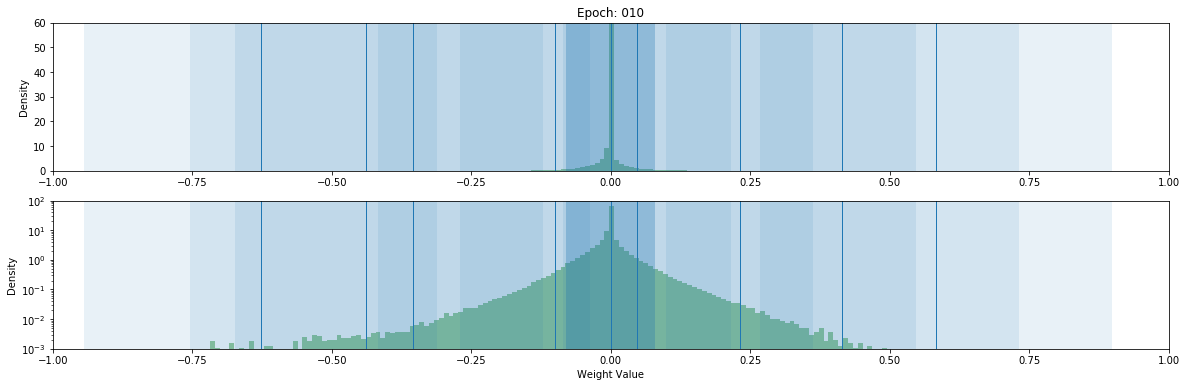

Epoch: 10. Test Accuracy: 96.74


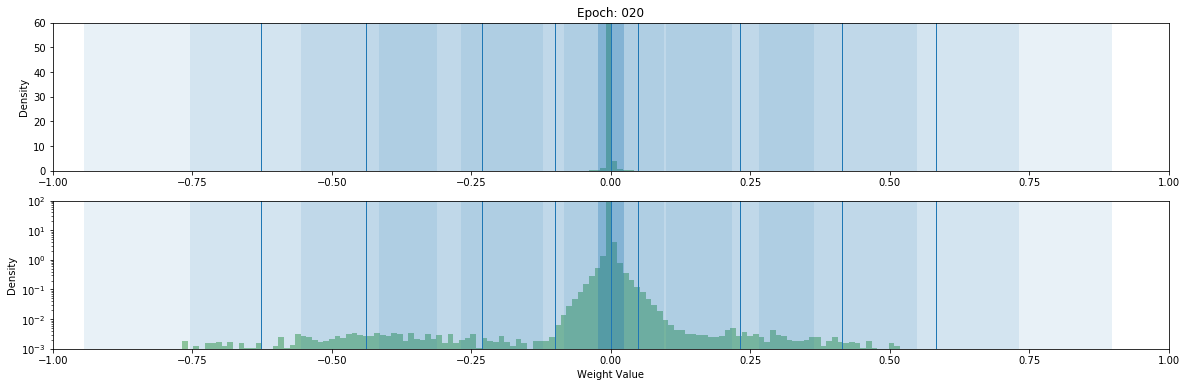

Epoch: 20. Test Accuracy: 96.79


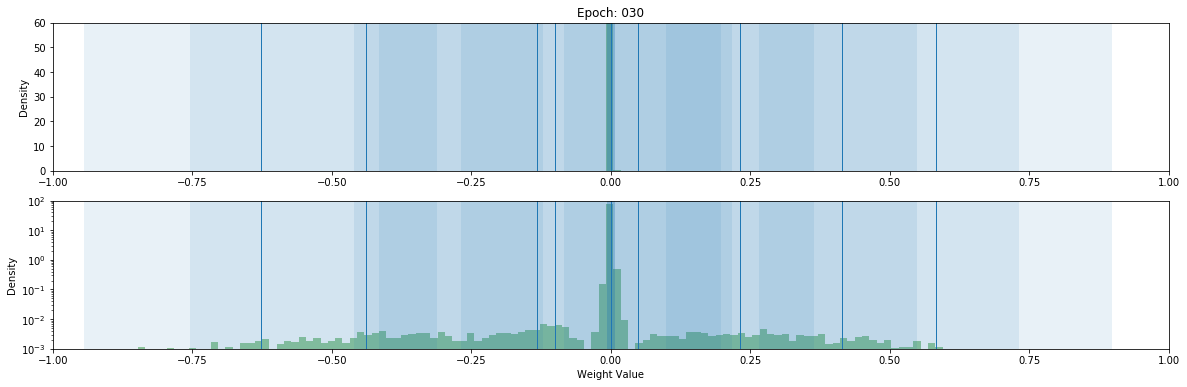

Epoch: 30. Test Accuracy: 97.36


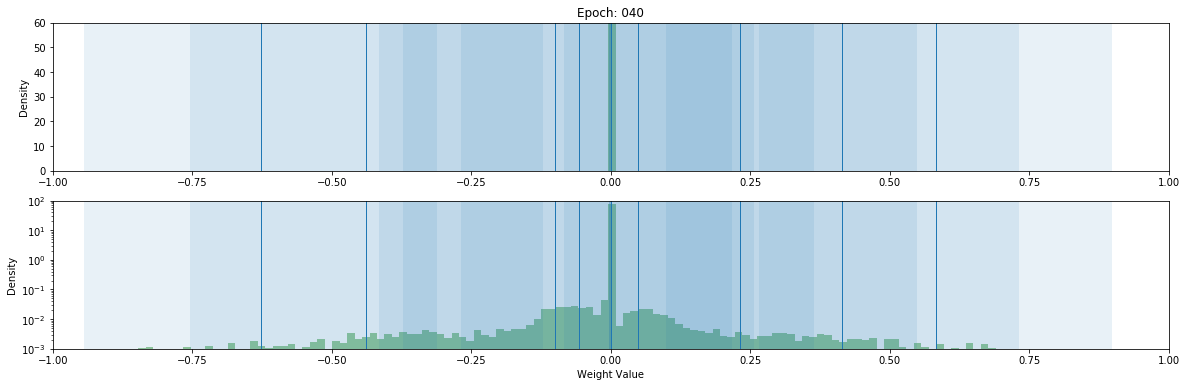

Epoch: 40. Test Accuracy: 97.51


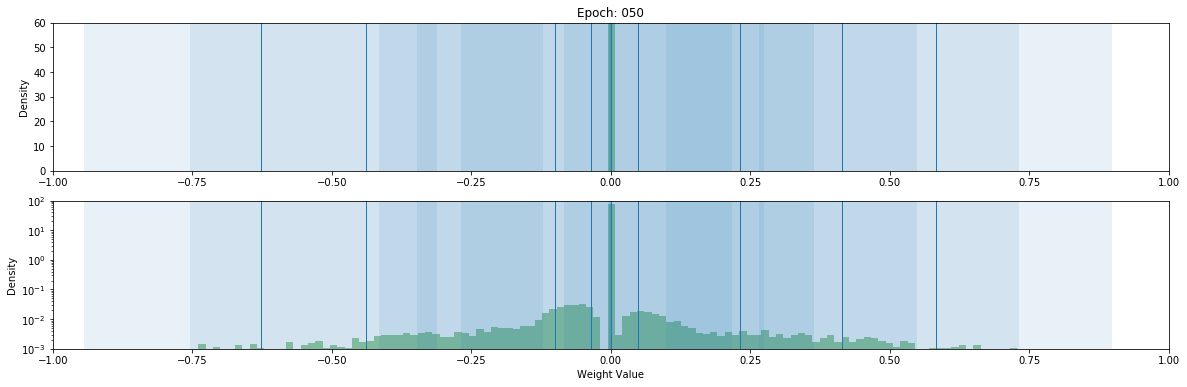

Epoch: 50. Test Accuracy: 97.63
[-0.53293234 -0.26880483 -0.06764668 -0.01789235  0.02416522  0.14011723
  0.32326275  0.49847168]
0
0
1
bet
2
bet
3
bet
4
bet
5
bet
6
bet
7
fin
Retrain Test: 97.63, Retrain Validation: 97.78, Prune Test: 95.44, Prune Validation: 95.77, Prune Sparsity: 99.29


In [80]:
model, gmp = retrain_model(alpha, beta, tau, temp, mixtures, 'SWSModel', 'search', (5e-3, 1e-4, 3e-3), "", False)

In [67]:
weights = special_flatten(model.state_dict()).clone().cpu().numpy()
means = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])

sorted_means = np.sort(means)
bins = (sorted_means[1:] + sorted_means[:-1])/2
for i, b in enumerate(bins):
    if (i==0):
        weights[np.where(weights < b)] = sorted_means[i]
    elif (i== len(bins) - 1):
        weights[np.where(weights > b)] = sorted_means[i]
    else:
        weights[np.where(np.logical_and(weights < b, weights > prev_b))] = sorted_means[i]
    prev_b = b

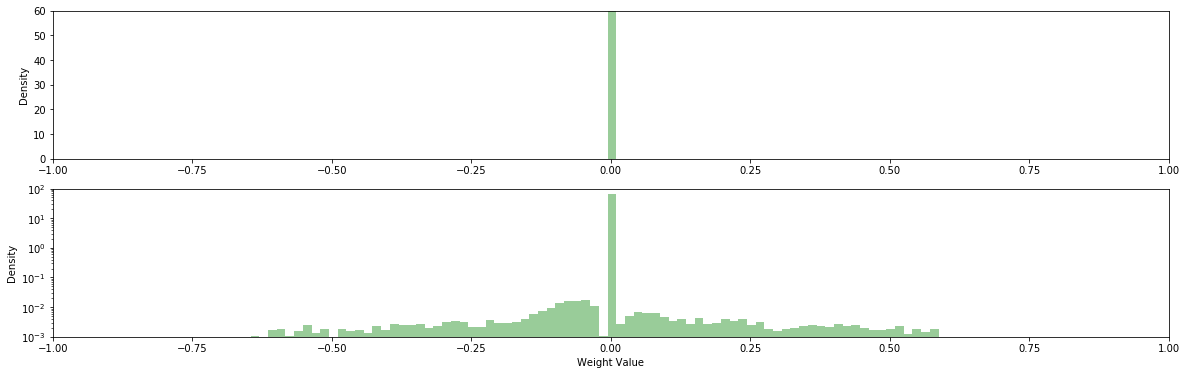

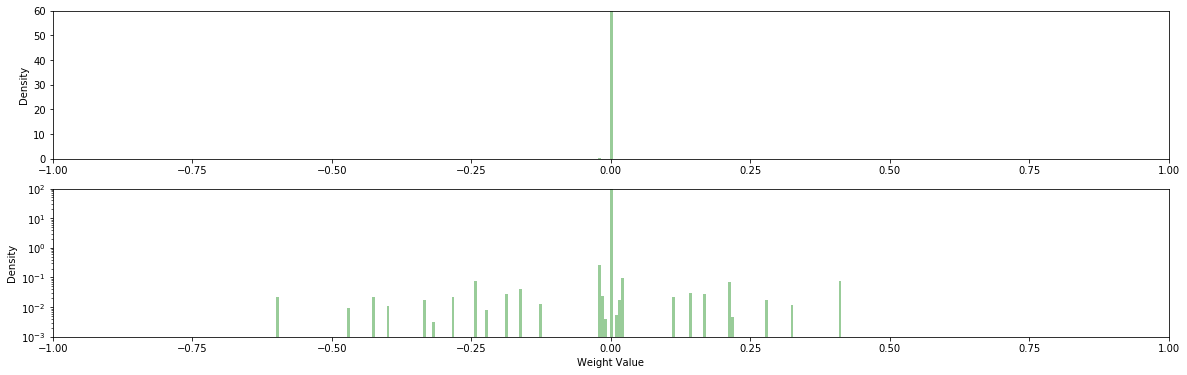

In [101]:
def sws_prune_l2(model, gmp):
    if (gmp.scaling):
        layer_mult = [float(gmp.scale[int(i/2)].exp()) for i in range(len(model.state_dict()))]
        weights = np.concatenate([model.state_dict()[array].clone().cpu().numpy().flatten() / layer_mult[i] for i, array in enumerate(model.state_dict())])
    else:
        weights = np.concatenate([model.state_dict()[array].clone().cpu().numpy().flatten() for i, array in enumerate(model.state_dict())])
    weights = weights.reshape((len(weights), 1))
    means = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
    
    sorted_means = np.sort(means)
    bins = (sorted_means[1:] + sorted_means[:-1])/2
    for i, b in enumerate(bins):
        if (i==0):
            weights[np.where(weights < b)] = sorted_means[i]
        elif (i== len(bins)-1):
            weights[np.where(weights > b)] = sorted_means[i]
            weights[np.where(np.logical_and(weights < b, weights > prev_b))] = sorted_means[i]
        else:
            weights[np.where(np.logical_and(weights < b, weights > prev_b))] = sorted_means[i]
        prev_b = b
    out = weights
    pruned_state_dict = copy.deepcopy(model.state_dict())
    dim_start = 0
    for i, layer in enumerate(model.state_dict()):
        layer_mult = 1
        if (gmp.scaling):
            layer_mult = float(gmp.scale[int(i/2)].exp())
        elems = model.state_dict()[layer].numel()
        pruned_state_dict[layer] = torch.from_numpy(np.array(out[dim_start:dim_start + elems]).reshape(model.state_dict()[layer].shape)) / layer_mult
        dim_start += elems
    return pruned_state_dict

show_sws_weights(model)
new_model = copy.deepcopy(model)
new_model.load_state_dict(sws_prune_l2(model,gmp))
show_sws_weights(new_model)

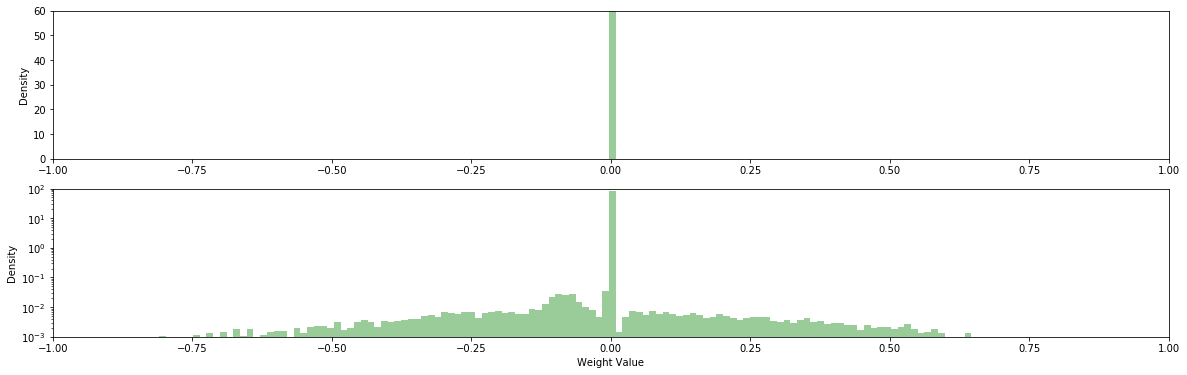

In [48]:
from utils_sws import sws_prune
show_sws_weights(model)

[-0.53453124 -0.268933   -0.07806969 -0.02840749  0.02518545  0.14197969
  0.32451408  0.49937406]
0
0
1
bet
2
bet
3
bet
4
bet
5
bet
6
bet
7
fin


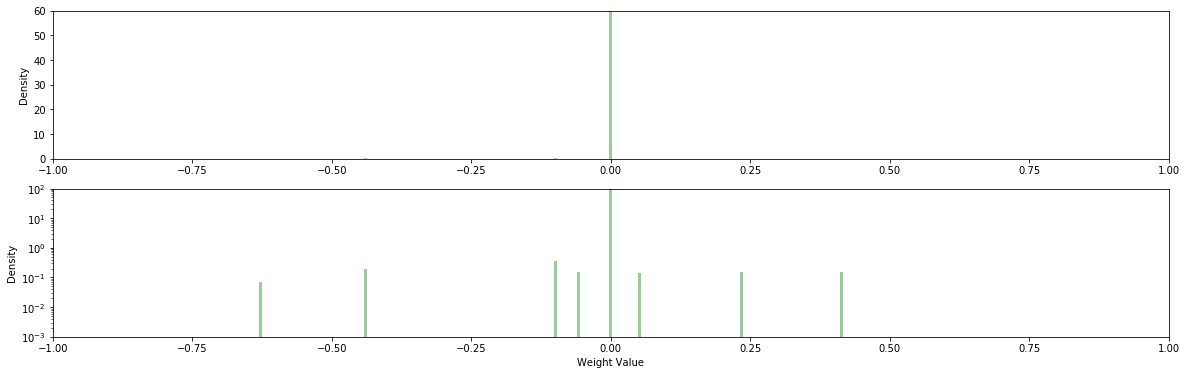

In [78]:
new_model = copy.deepcopy(model)
new_model.load_state_dict(sws_prune_l2(model,gmp))
show_sws_weights(new_model)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


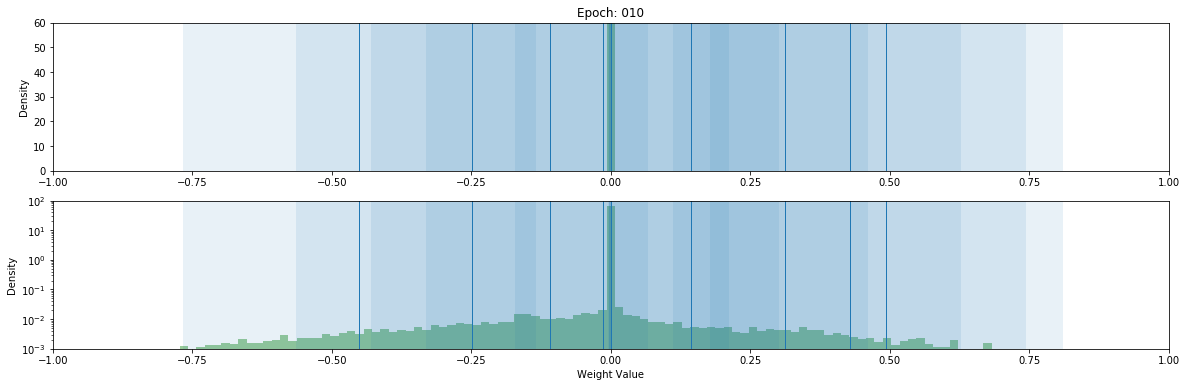

Epoch: 10. Test Accuracy: 98.42


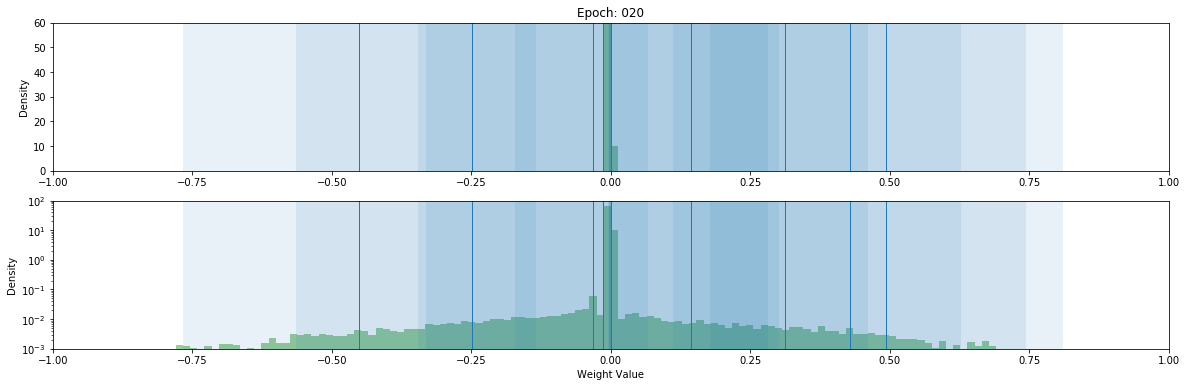

Epoch: 20. Test Accuracy: 98.55


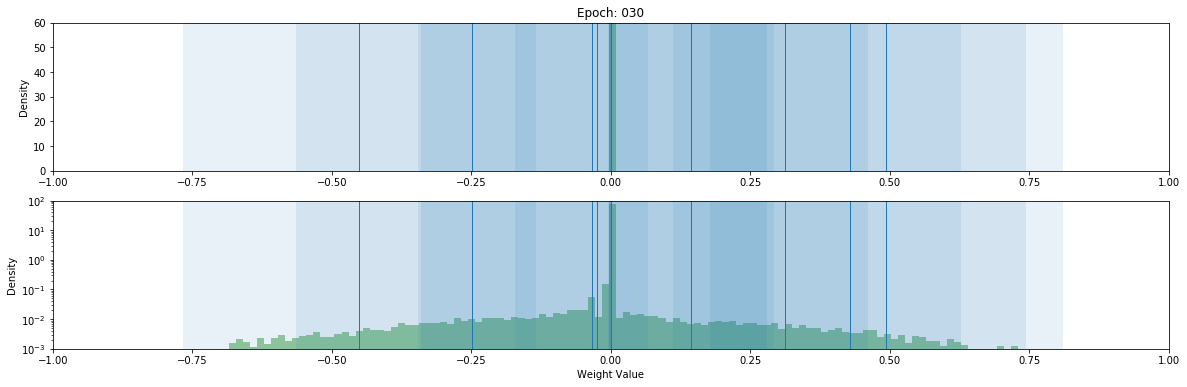

Epoch: 30. Test Accuracy: 98.70


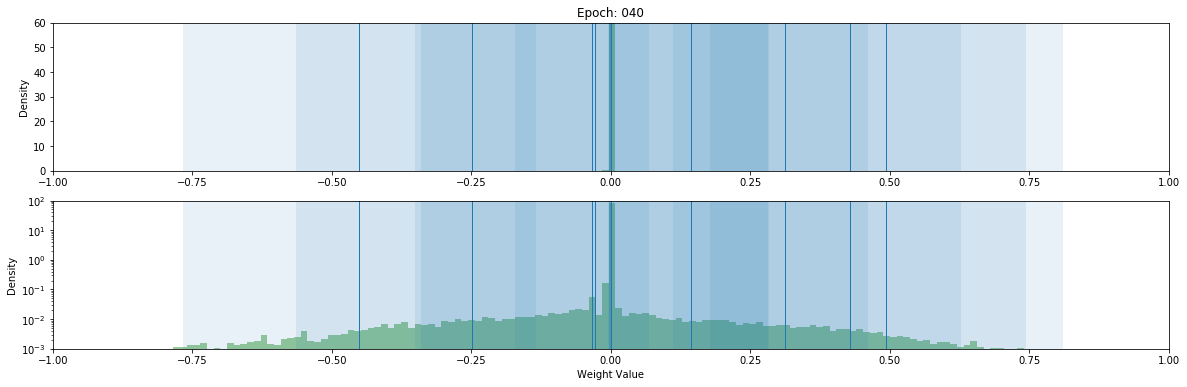

Epoch: 40. Test Accuracy: 98.59


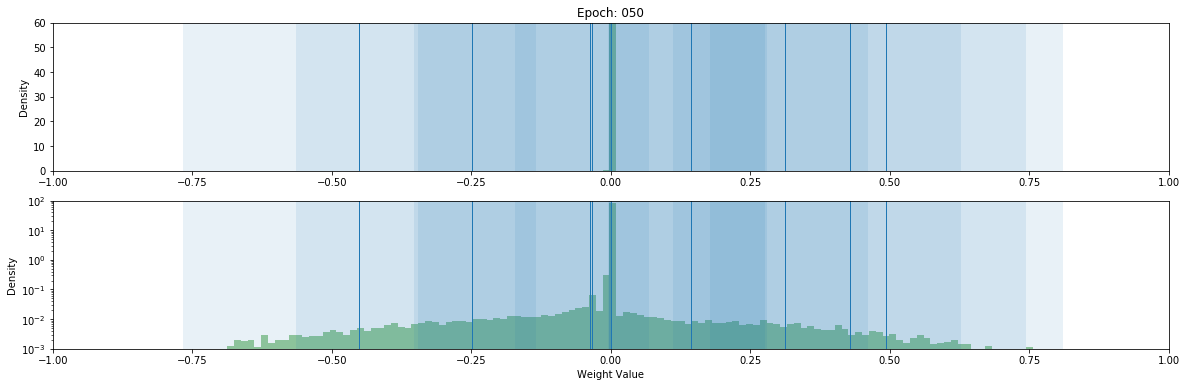

Epoch: 50. Test Accuracy: 98.53
[-0.34965503 -0.14264694 -0.03561429 -0.01728978  0.07220909  0.22817187
  0.37012203  0.46080497]
0
0
1
bet
2
bet
3
bet
4
bet
5
bet
6
bet
7
fin
Retrain Test: 98.53, Retrain Validation: 0.00, Prune Test: 97.53, Prune Validation: 0.00, Prune Sparsity: 99.07


In [81]:
model, gmp = retrain_model(alpha, beta, tau, temp, mixtures, 'SWSModel', 'full', (5e-3, 1e-4, 3e-3), "", False)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


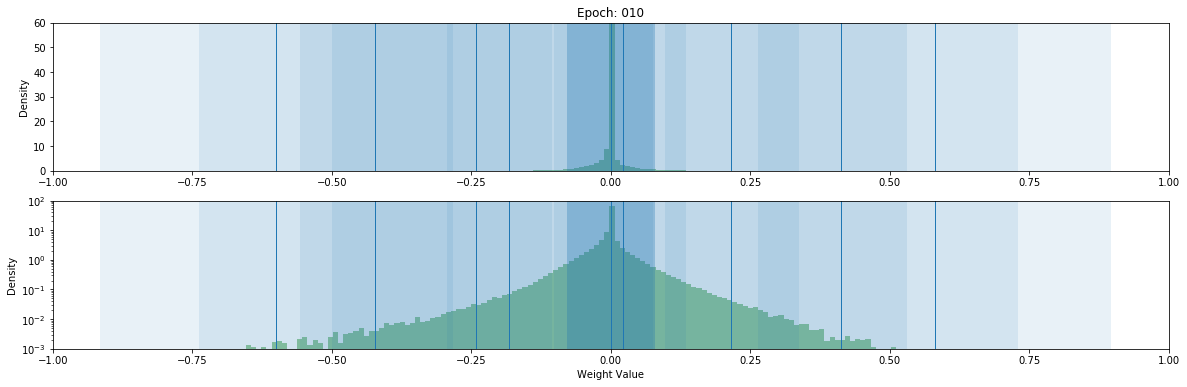

Epoch: 10. Test Accuracy: 94.44


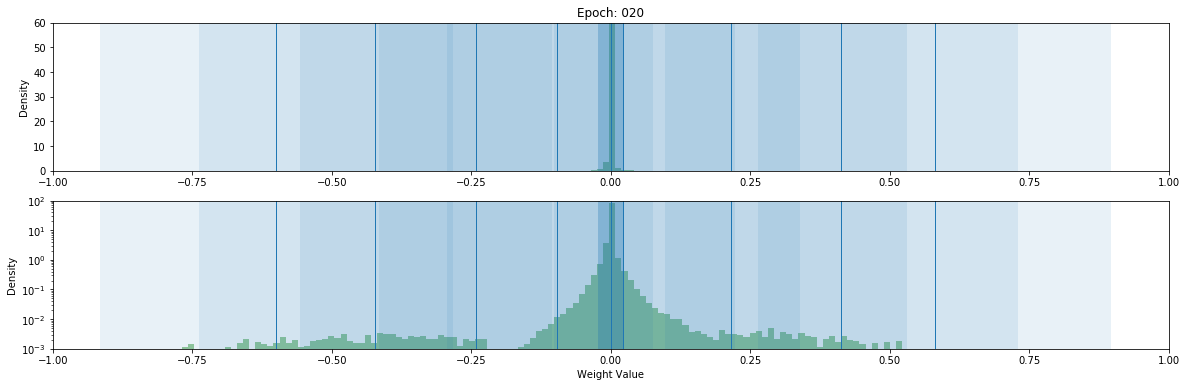

Epoch: 20. Test Accuracy: 96.79


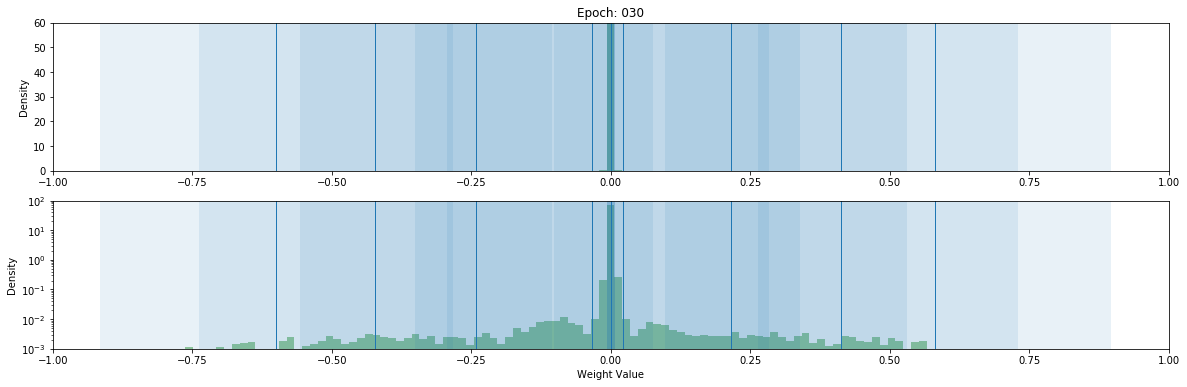

Epoch: 30. Test Accuracy: 97.15


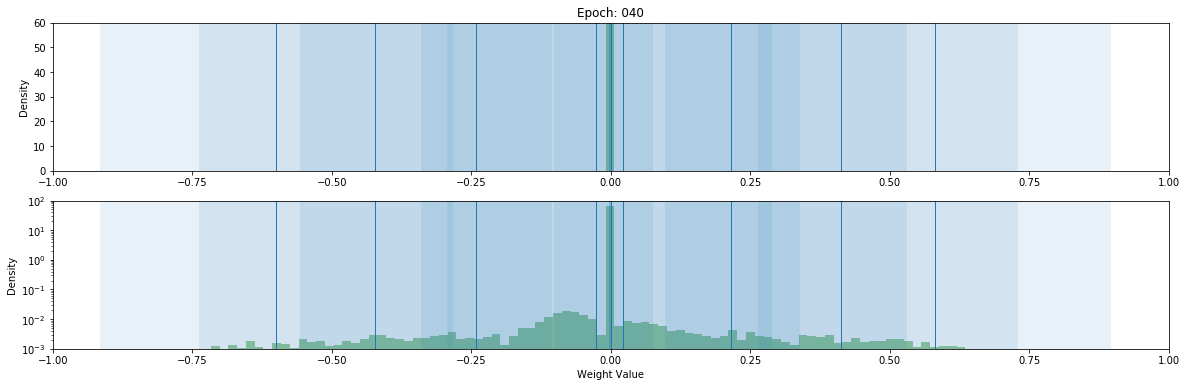

Epoch: 40. Test Accuracy: 97.36


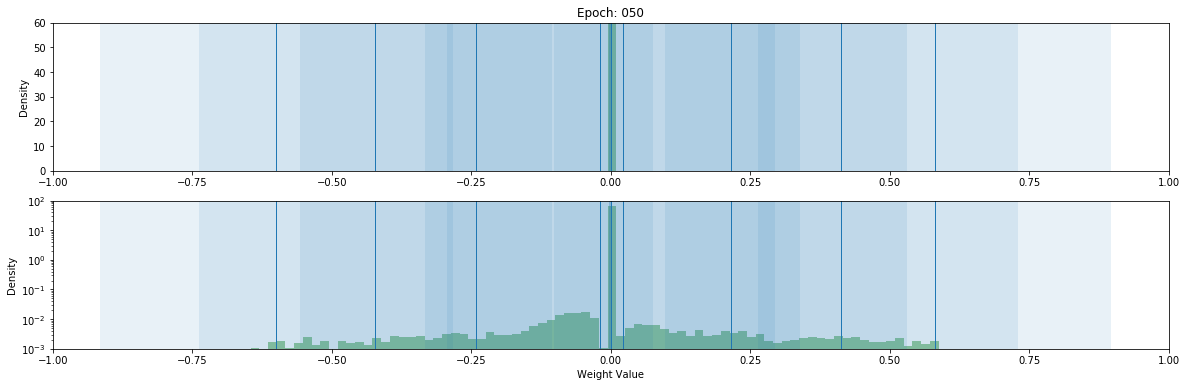

Epoch: 50. Test Accuracy: 97.23
[-0.51077338 -0.33184043 -0.13045703 -0.00976943  0.01113052  0.1186233
  0.31406387  0.49696864]
0
1
2
3
4
5
6
7
Retrain Test: 97.23, Retrain Validation: 97.48, Prune Test: 95.49, Prune Validation: 95.83, Prune Sparsity: 99.52


In [94]:
model, gmp = retrain_model(alpha, beta, tau, temp, mixtures, 'SWSModel', 'search', (5e-3, 1e-4, 3e-3), "", True)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


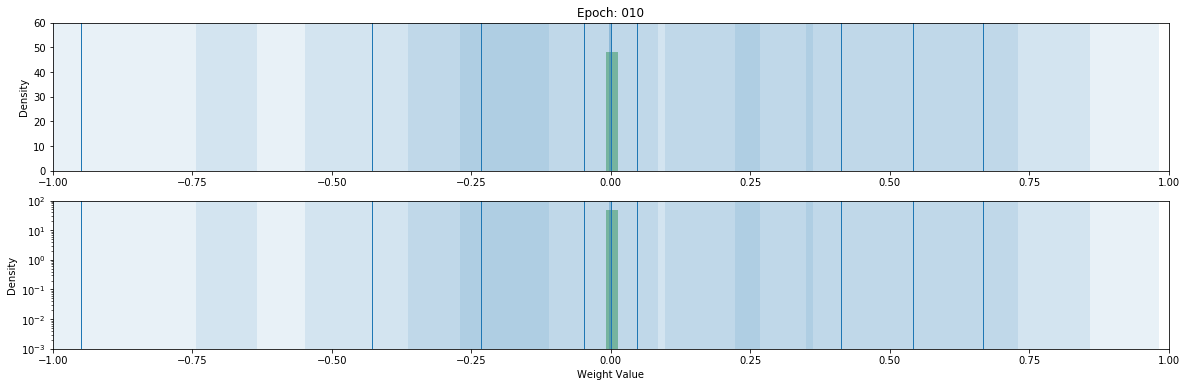

Epoch: 10. Test Accuracy: 83.15


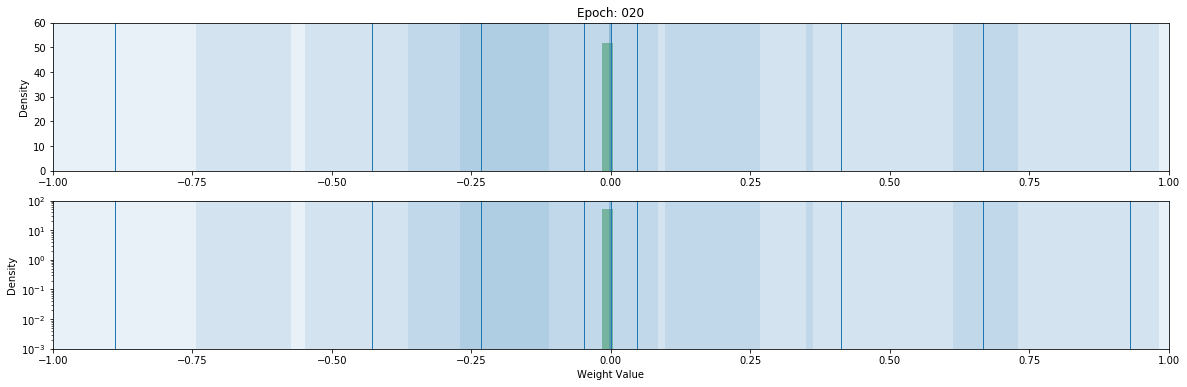

Epoch: 20. Test Accuracy: 83.29


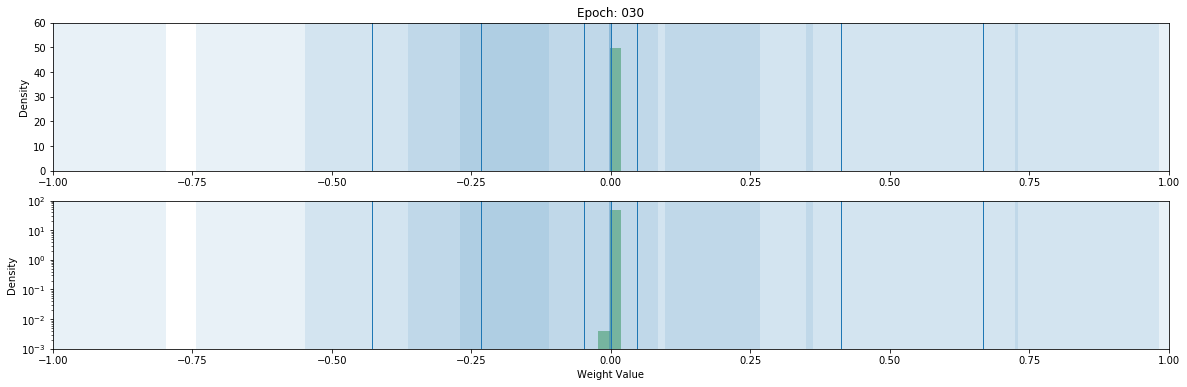

Epoch: 30. Test Accuracy: 82.94


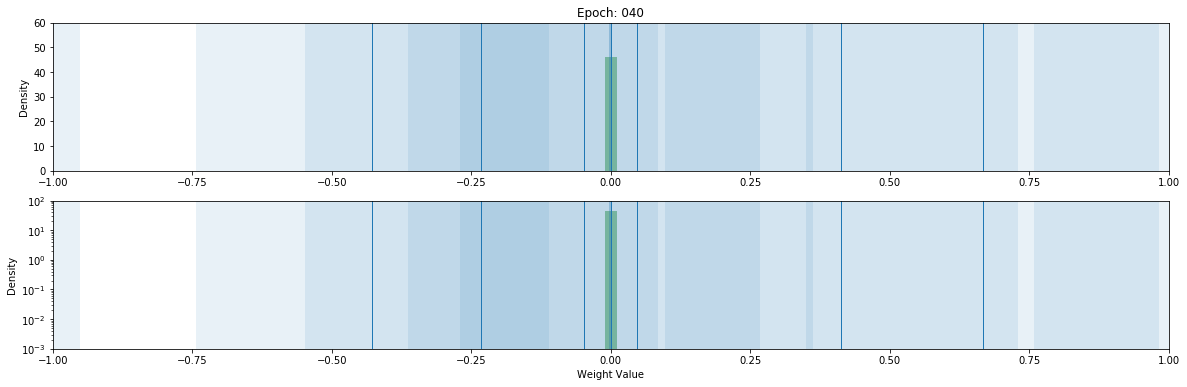

Epoch: 40. Test Accuracy: 83.33


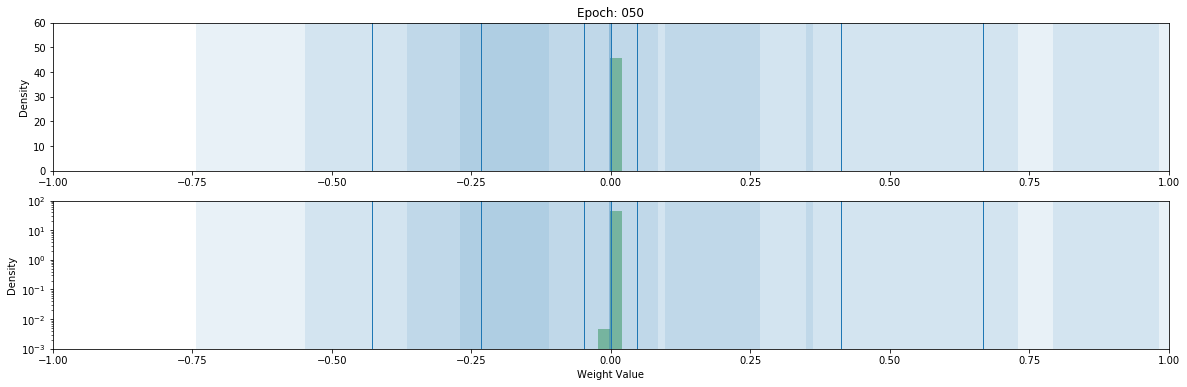

Epoch: 50. Test Accuracy: 83.29
[-0.89532012 -0.32975174 -0.14003672 -0.02408071  0.02313791  0.2294451
  0.53936134  0.88752517]
0
0
1
bet
2
bet
3
bet
4
bet
5
bet
6
bet
7
fin
Retrain Test: 83.29, Retrain Validation: 0.00, Prune Test: 62.03, Prune Validation: 0.00, Prune Sparsity: 99.99


In [83]:
model, gmp = retrain_model(alpha, beta, tau, 0, mixtures, 'SWSModel', 'full', (5e-3, 1e-4, 3e-3), "", False)

Temp: 1
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


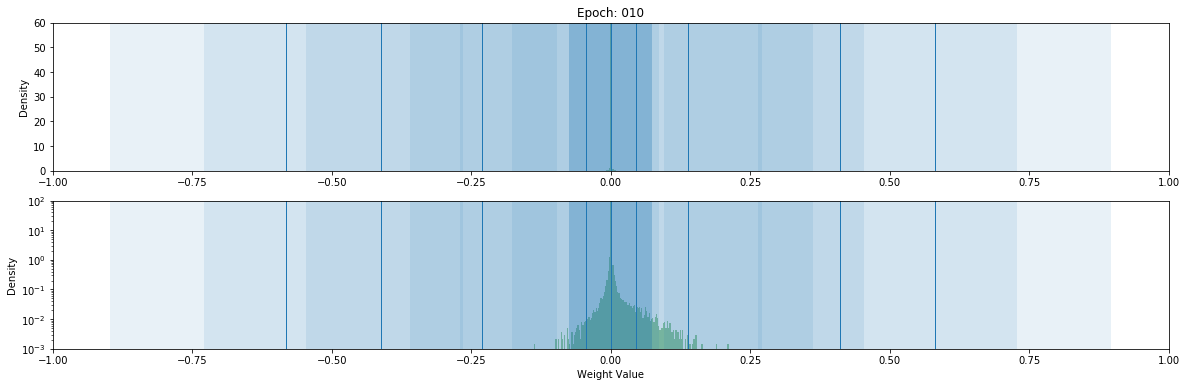

Epoch: 10. Test Accuracy: 65.59


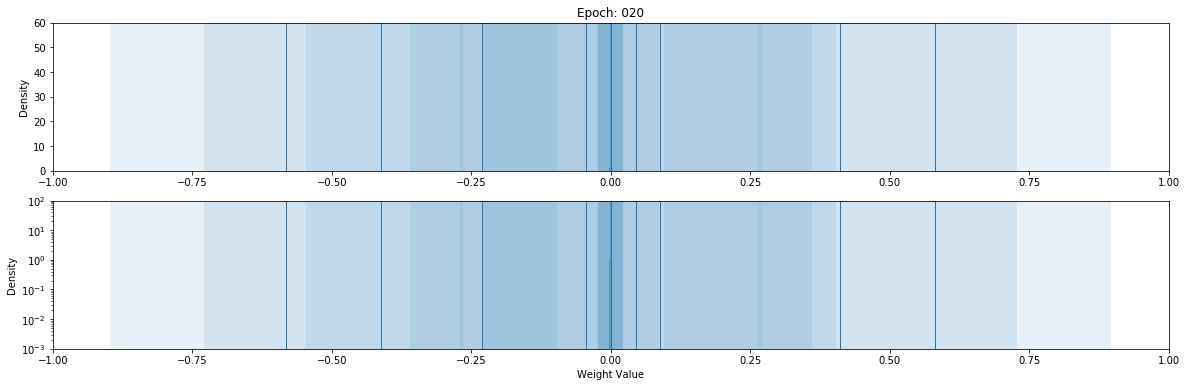

Epoch: 20. Test Accuracy: 8.92


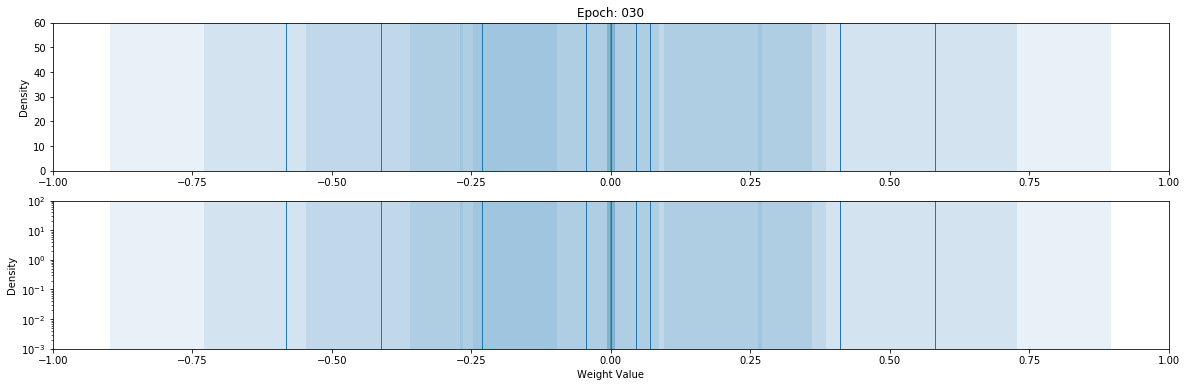

Epoch: 30. Test Accuracy: 10.09


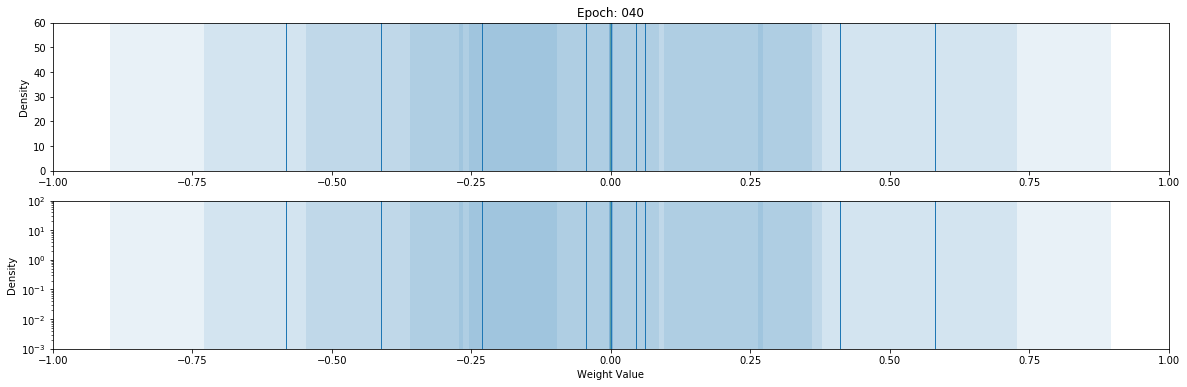

Epoch: 40. Test Accuracy: 9.58


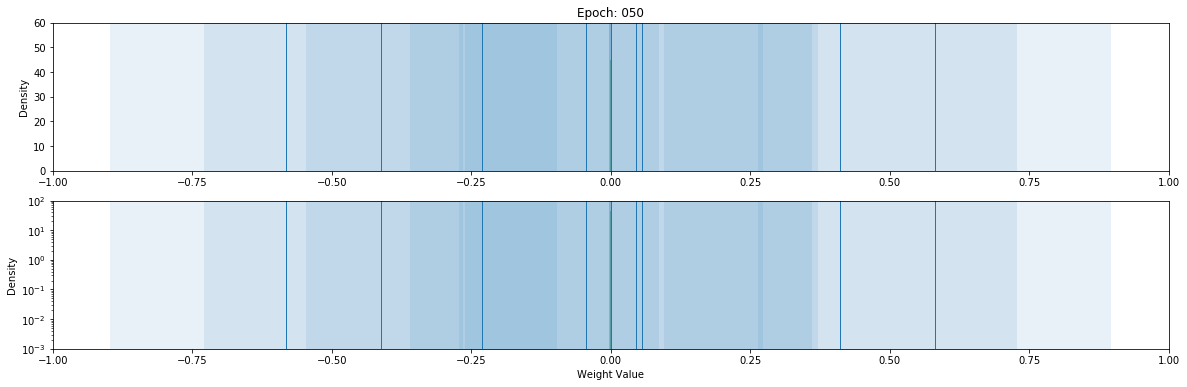

Epoch: 50. Test Accuracy: 10.09
[-0.49704093 -0.32136367 -0.1373816  -0.02209355  0.0224638   0.05029105
  0.23357544  0.49597053]
0
1
2
3
4
5
6
7
Retrain Test: 10.09, Retrain Validation: 9.61, Prune Test: 9.80, Prune Validation: 9.91, Prune Sparsity: 100.00
Temp: 5
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


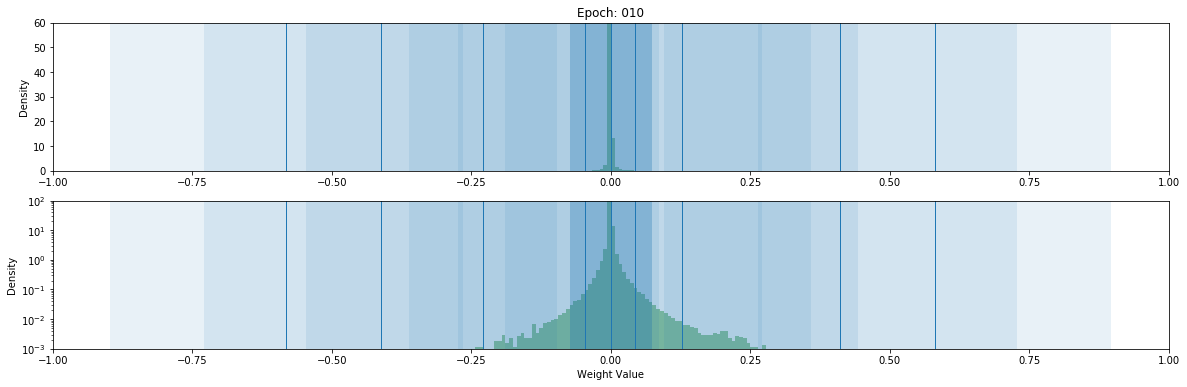

Epoch: 10. Test Accuracy: 94.37


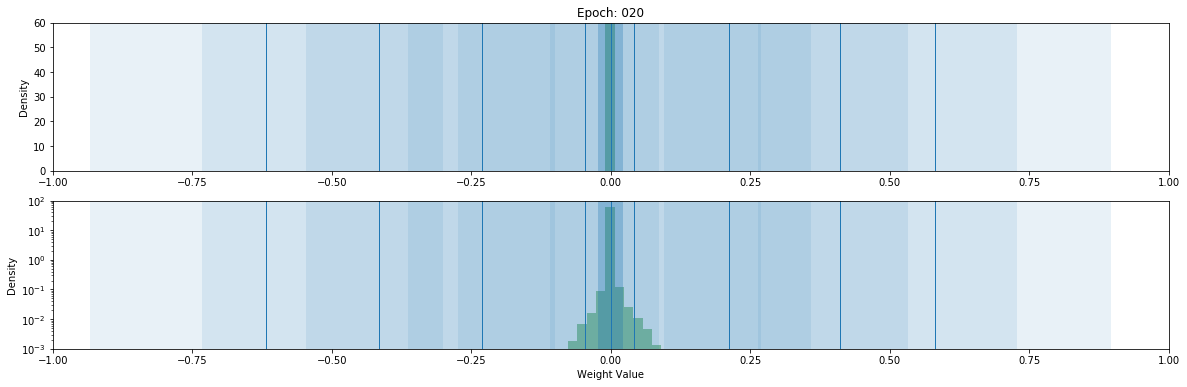

Epoch: 20. Test Accuracy: 92.79


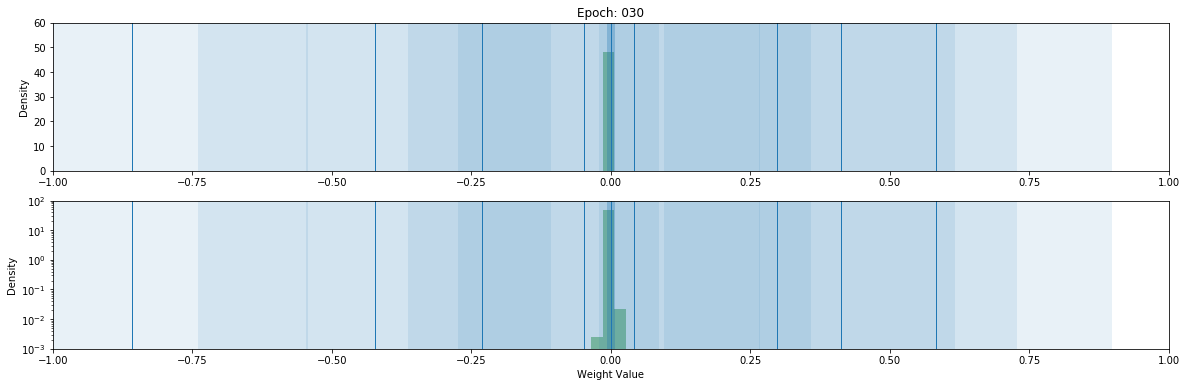

Epoch: 30. Test Accuracy: 91.74


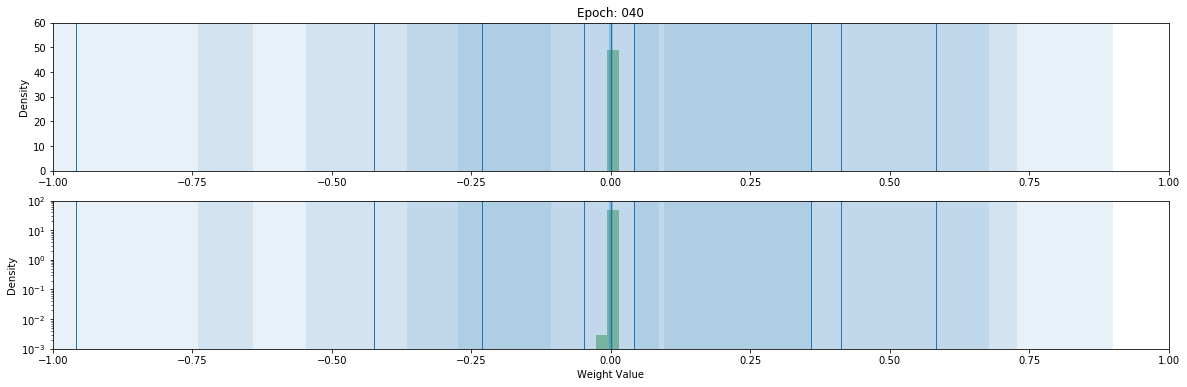

Epoch: 40. Test Accuracy: 90.94


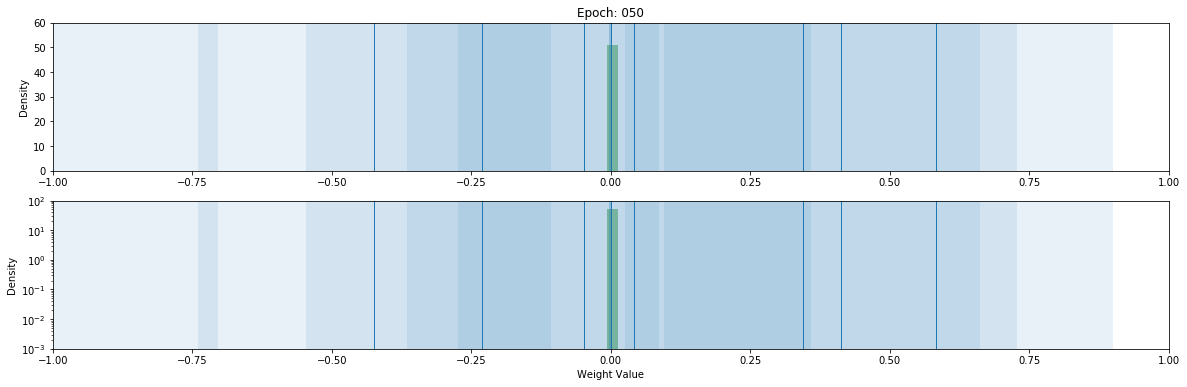

Epoch: 50. Test Accuracy: 91.56
[-0.7218871  -0.32714511 -0.13960772 -0.02422055  0.02089945  0.19274201
  0.37768546  0.49744375]
0
1
2
3
4
5
6
7
Retrain Test: 91.56, Retrain Validation: 91.98, Prune Test: 68.39, Prune Validation: 69.82, Prune Sparsity: 99.97
Temp: 9
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


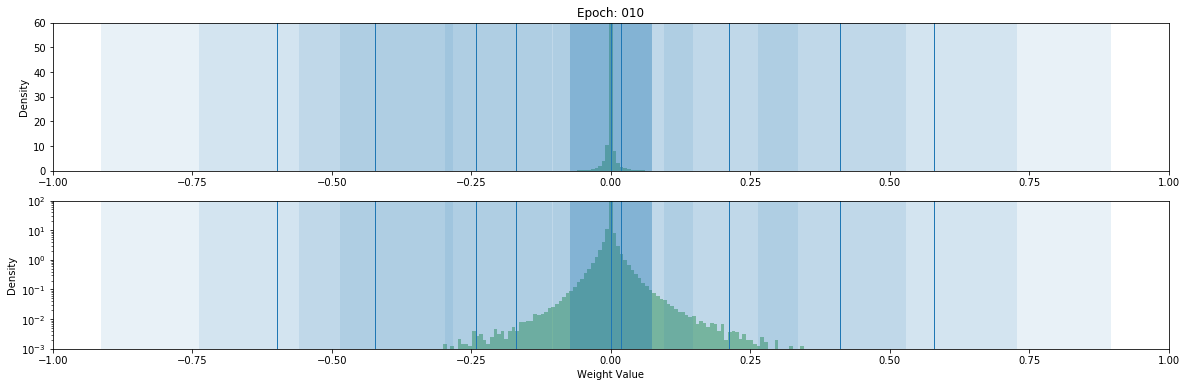

Epoch: 10. Test Accuracy: 96.97


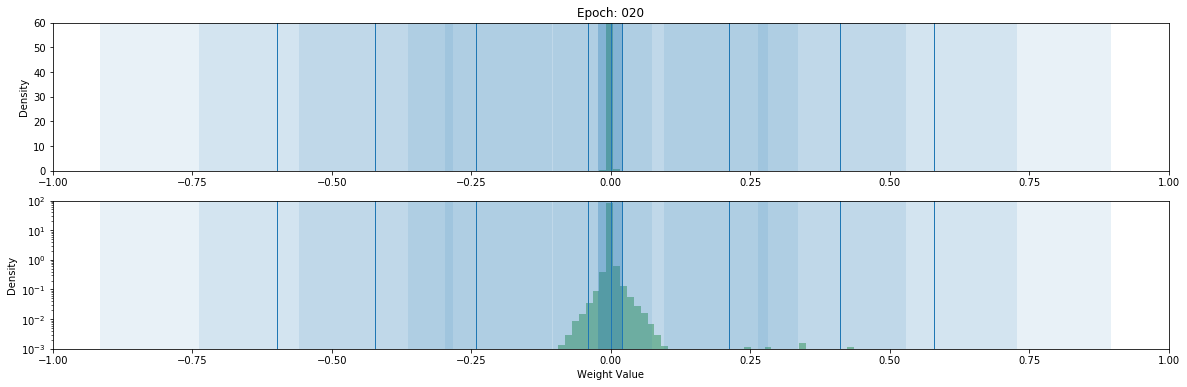

Epoch: 20. Test Accuracy: 95.08


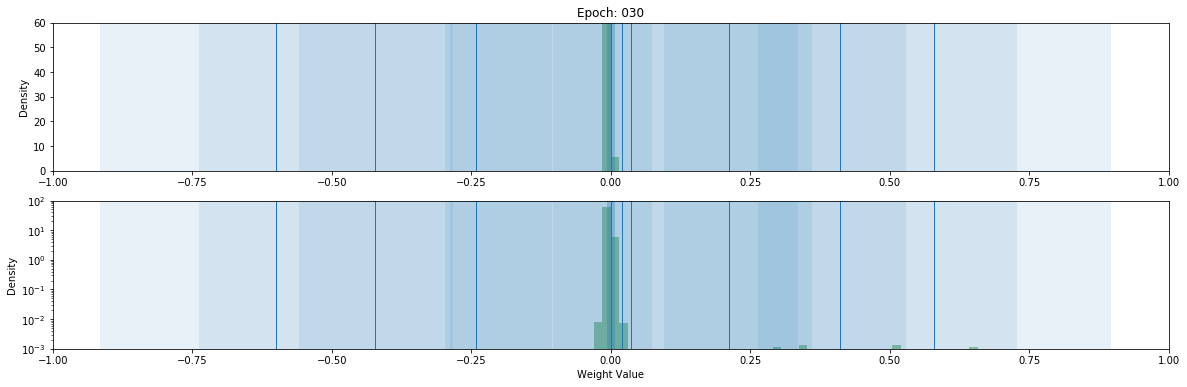

Epoch: 30. Test Accuracy: 94.40


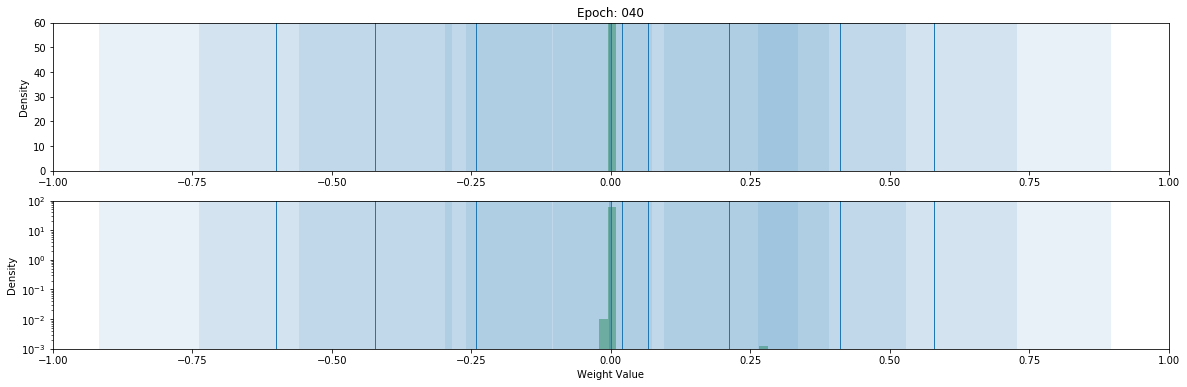

Epoch: 40. Test Accuracy: 95.53


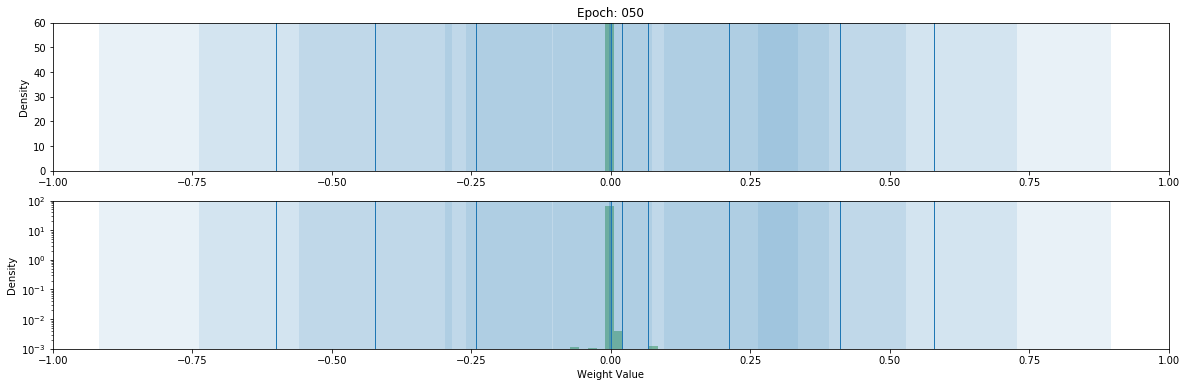

Epoch: 50. Test Accuracy: 95.99
[-0.51130658 -0.3321131  -0.12104742  0.00961788  0.04253089  0.13902339
  0.31180275  0.49553949]
0
1
2
3
4
5
6
7
Retrain Test: 95.99, Retrain Validation: 96.24, Prune Test: 55.94, Prune Validation: 56.13, Prune Sparsity: 99.92
Temp: 13
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


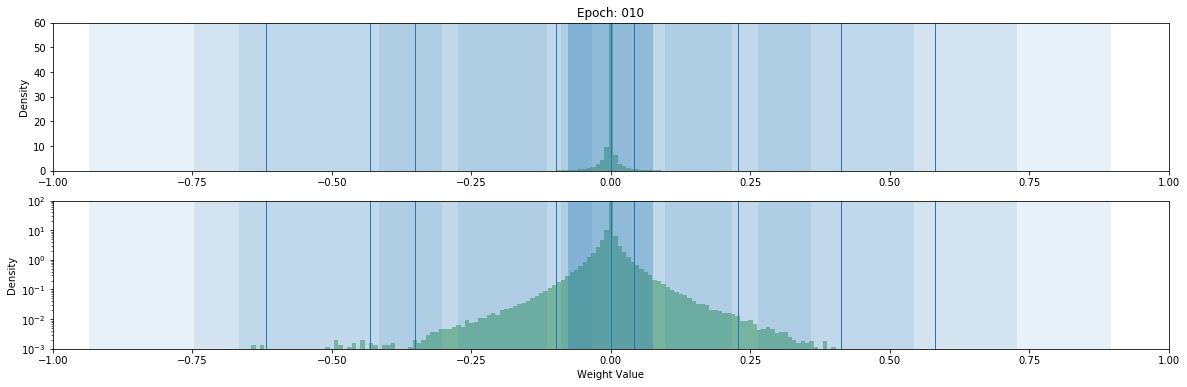

Epoch: 10. Test Accuracy: 96.72


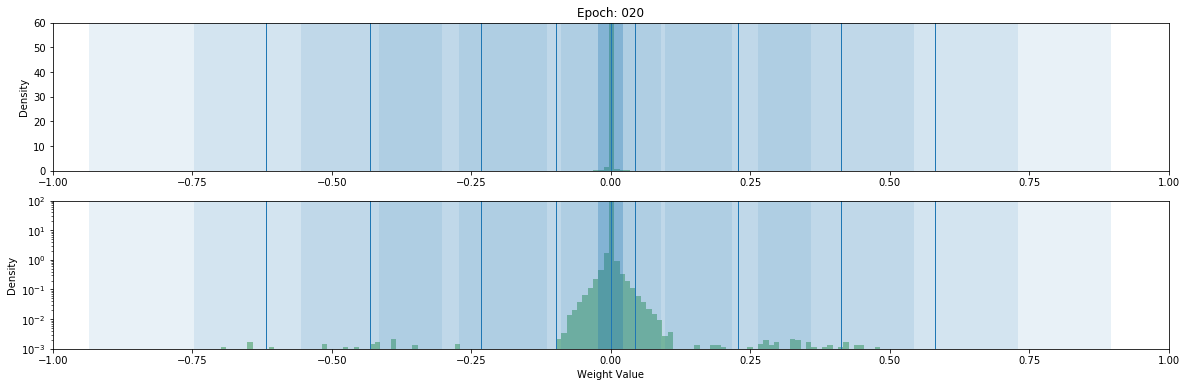

Epoch: 20. Test Accuracy: 95.63


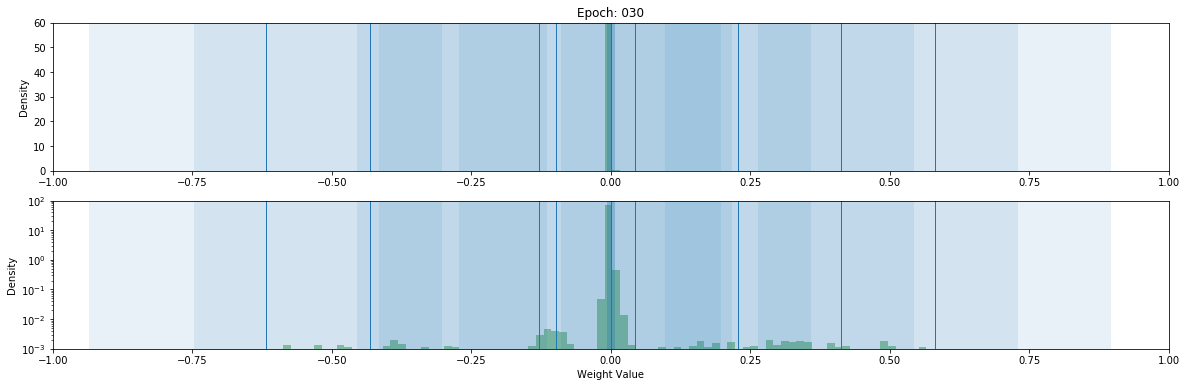

Epoch: 30. Test Accuracy: 96.63


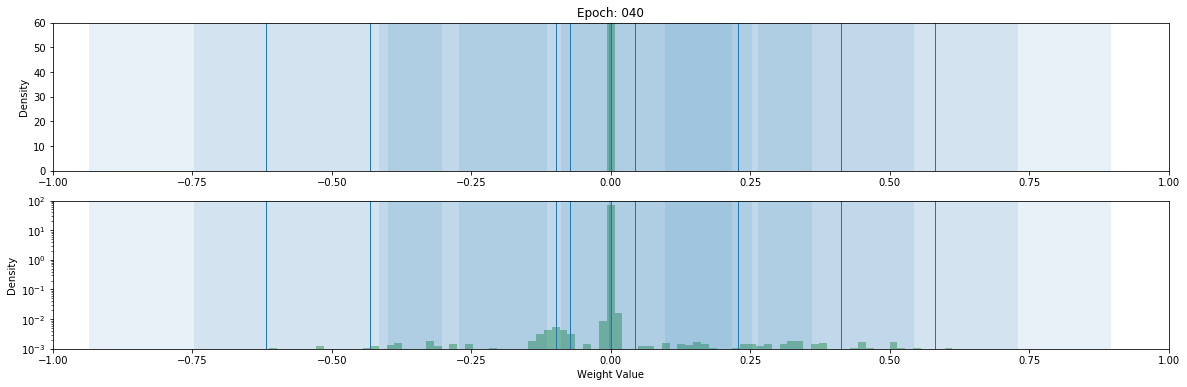

Epoch: 40. Test Accuracy: 96.78


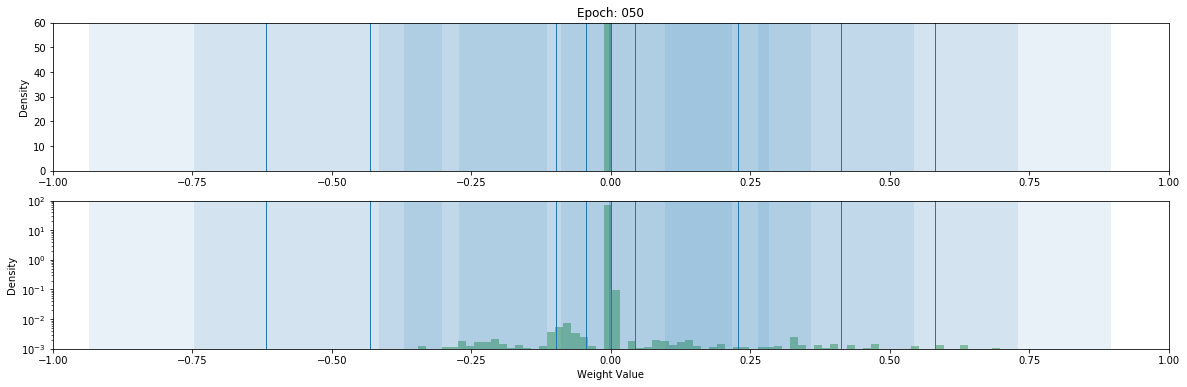

Epoch: 50. Test Accuracy: 96.73
[-0.52500525 -0.26483043 -0.07122772 -0.02206979  0.02164094  0.13545208
  0.32012283  0.49646948]
0
1
2
3
4
5
6
7
Retrain Test: 96.73, Retrain Validation: 96.89, Prune Test: 88.33, Prune Validation: 88.97, Prune Sparsity: 99.81
Temp: 17
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


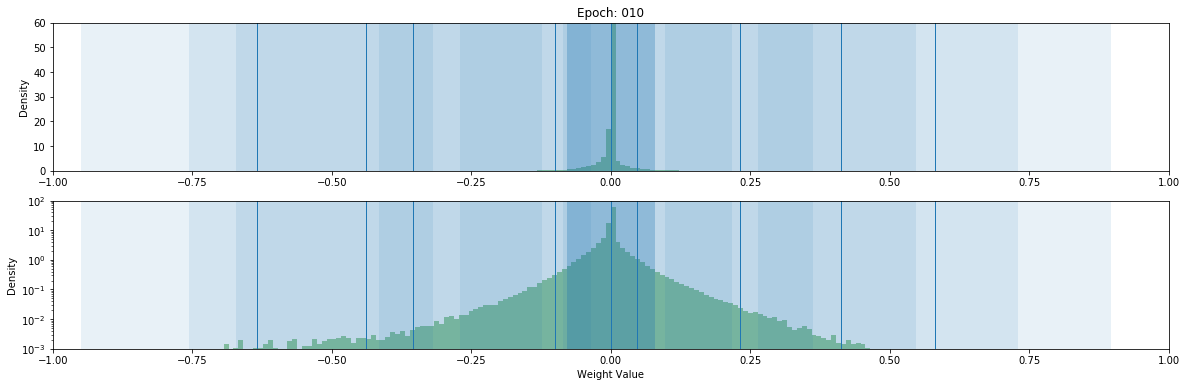

Epoch: 10. Test Accuracy: 96.43


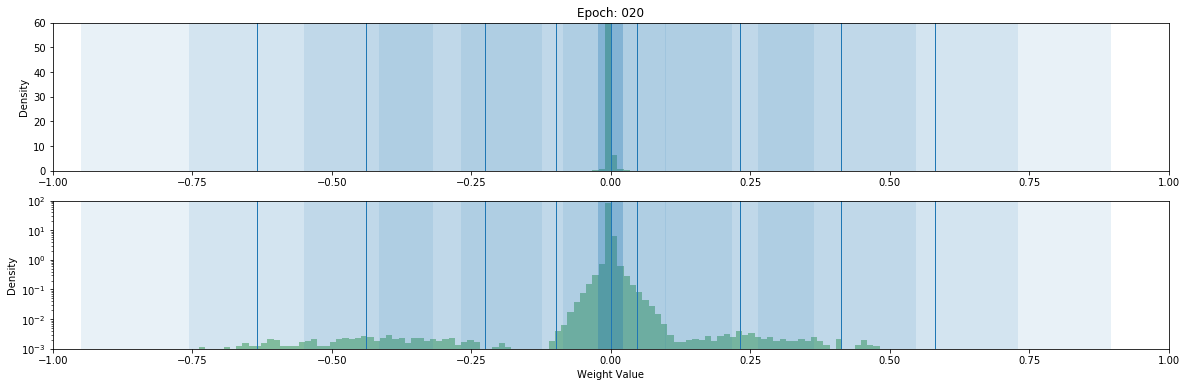

Epoch: 20. Test Accuracy: 95.76


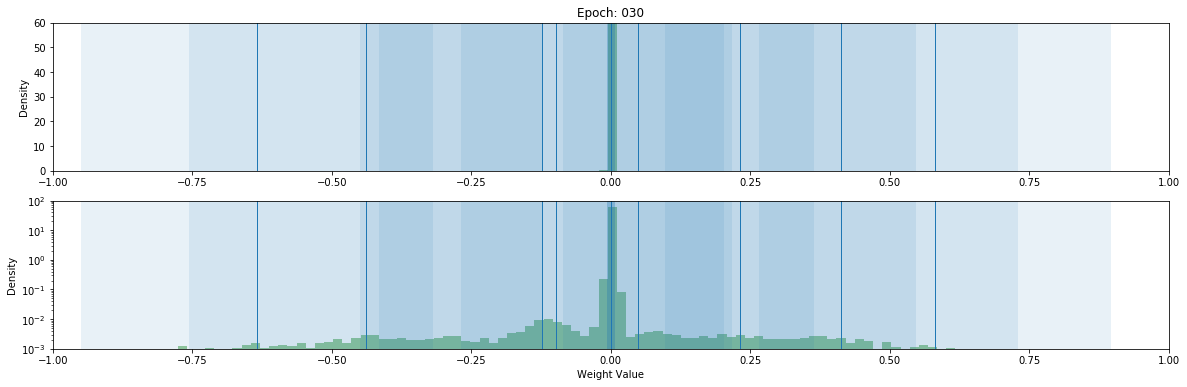

Epoch: 30. Test Accuracy: 97.21


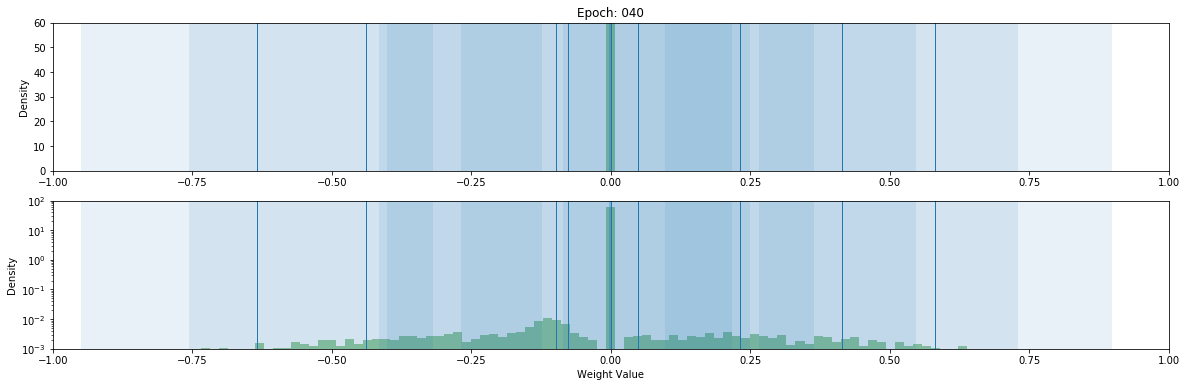

Epoch: 40. Test Accuracy: 97.54


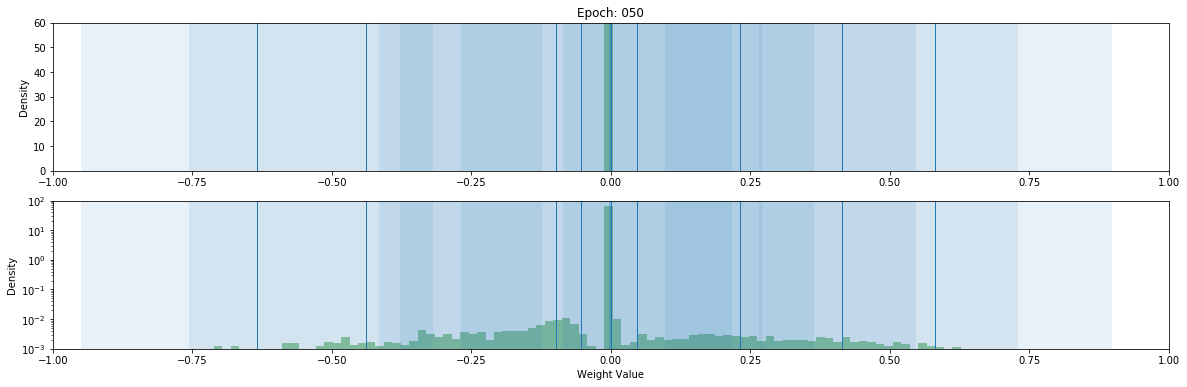

Epoch: 50. Test Accuracy: 97.48
[-0.53662576 -0.26896552 -0.07595968 -0.02656233  0.02388748  0.13950812
  0.32232879  0.49740346]
0
1
2
3
4
5
6
7
Retrain Test: 97.48, Retrain Validation: 97.48, Prune Test: 95.04, Prune Validation: 95.54, Prune Sparsity: 99.66


In [89]:
for temp in range (1, 20, 4):
    print ("Temp: {}".format(temp))
    model, gmp = retrain_model(alpha, beta, tau, float(temp), mixtures, 'SWSModel', 'search', (5e-3, 1e-4, 3e-3), "", False)

Temp: 1
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


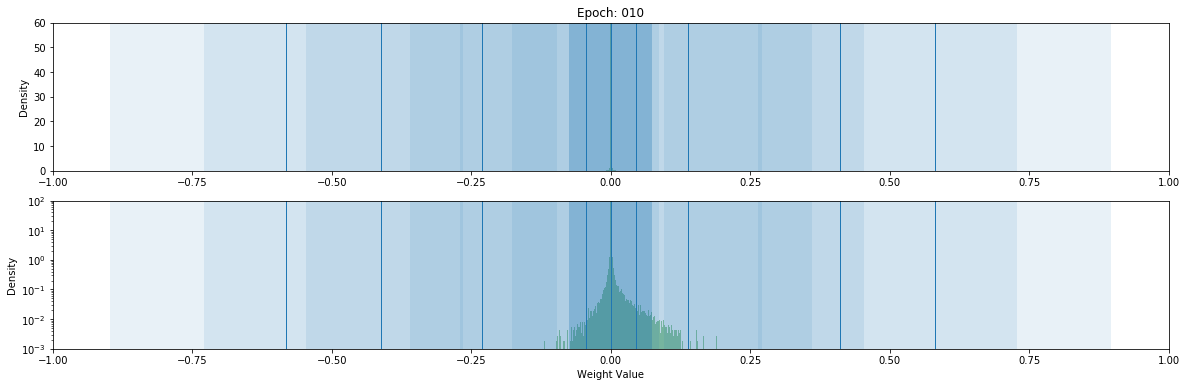

Epoch: 10. Test Accuracy: 65.60


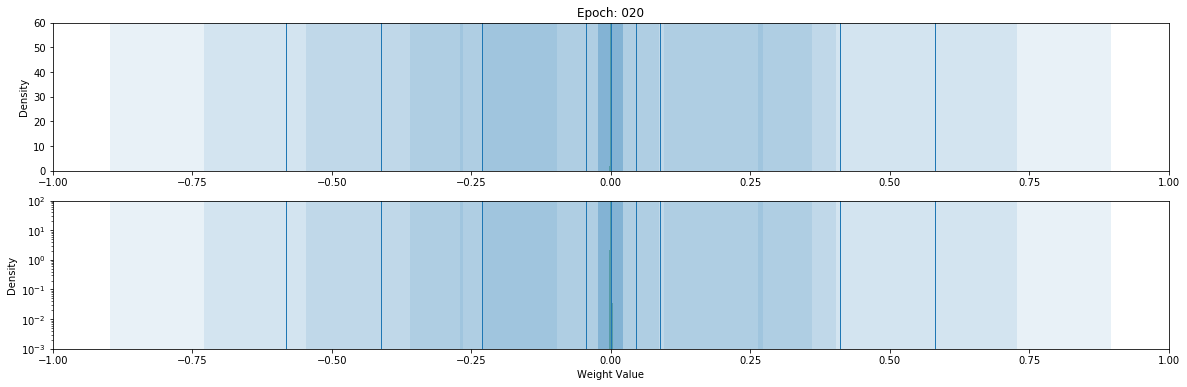

Epoch: 20. Test Accuracy: 9.82


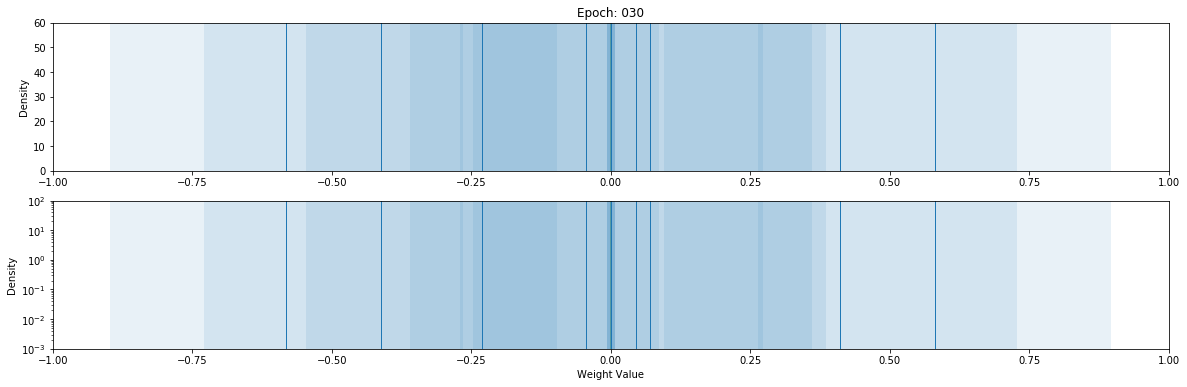

Epoch: 30. Test Accuracy: 10.10


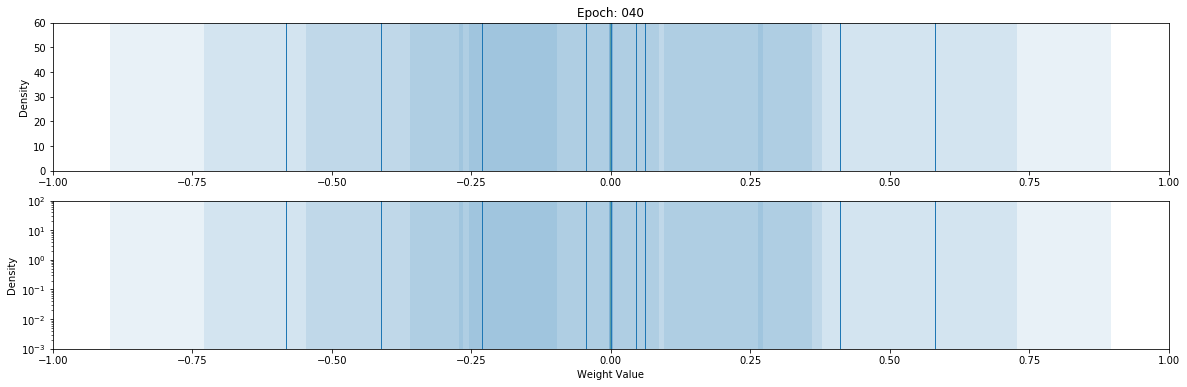

Epoch: 40. Test Accuracy: 9.82


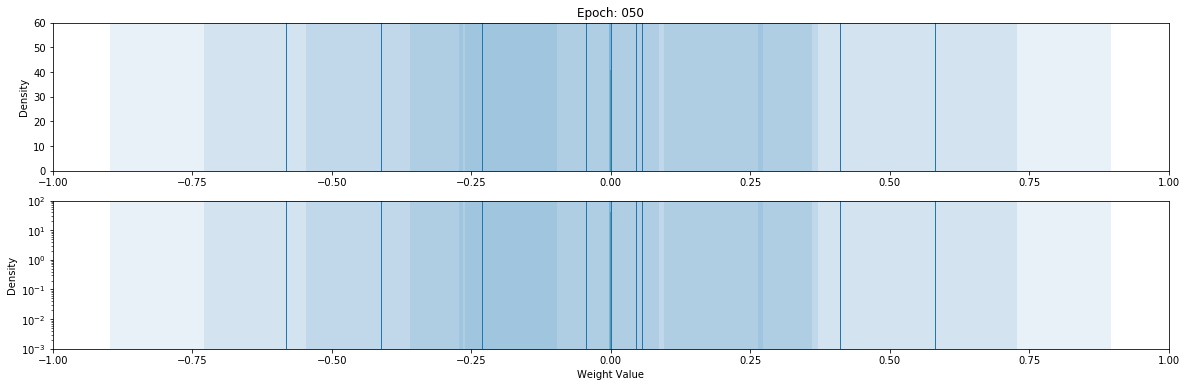

Epoch: 50. Test Accuracy: 9.74
[-0.49704005 -0.32135619 -0.13735453 -0.02207247  0.02243689  0.05024205
  0.23355439  0.49597587]
0
1
2
3
4
5
6
7
Retrain Test: 9.74, Retrain Validation: 10.09, Prune Test: 9.80, Prune Validation: 9.91, Prune Sparsity: 100.00
Temp: 5
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


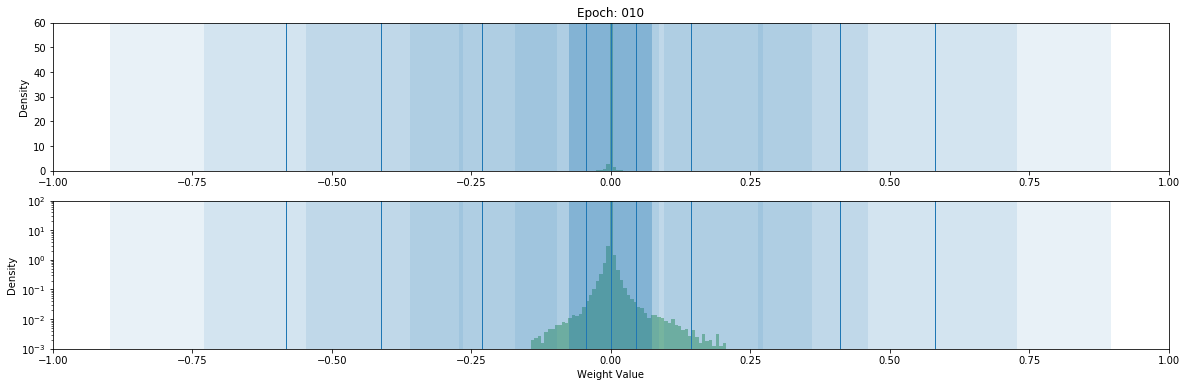

Epoch: 10. Test Accuracy: 86.47


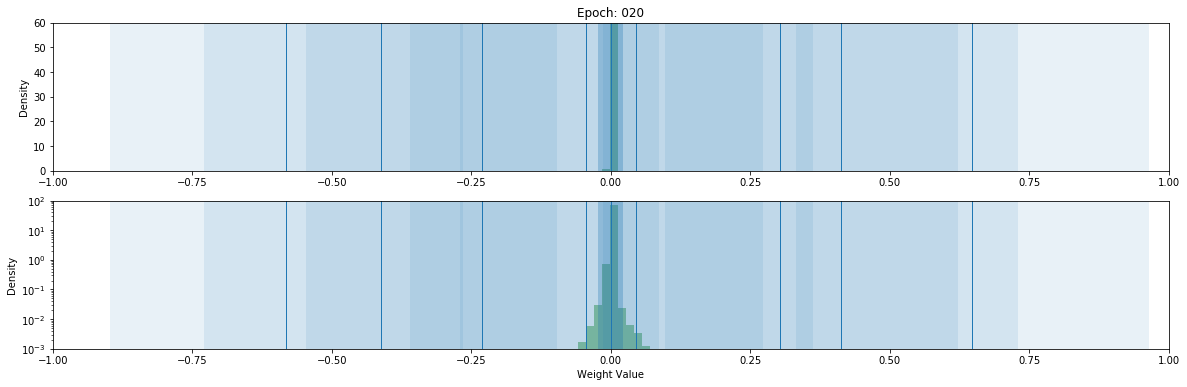

Epoch: 20. Test Accuracy: 85.60


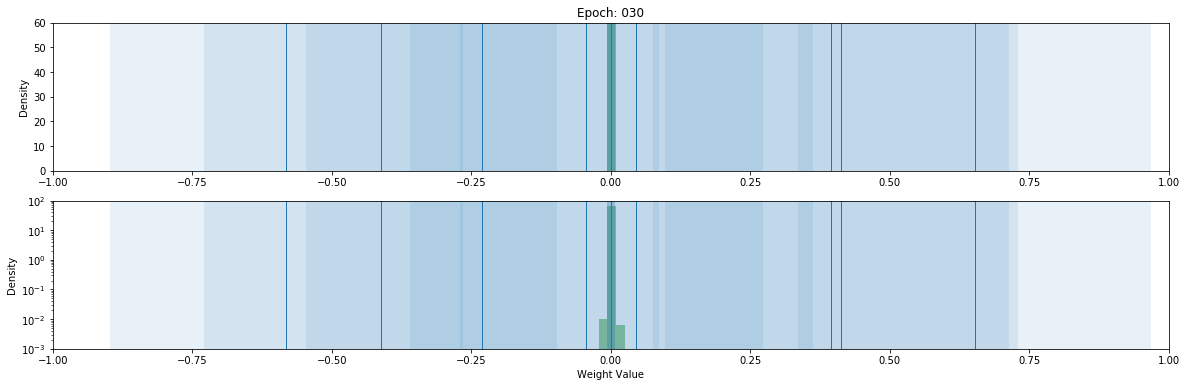

Epoch: 30. Test Accuracy: 75.84


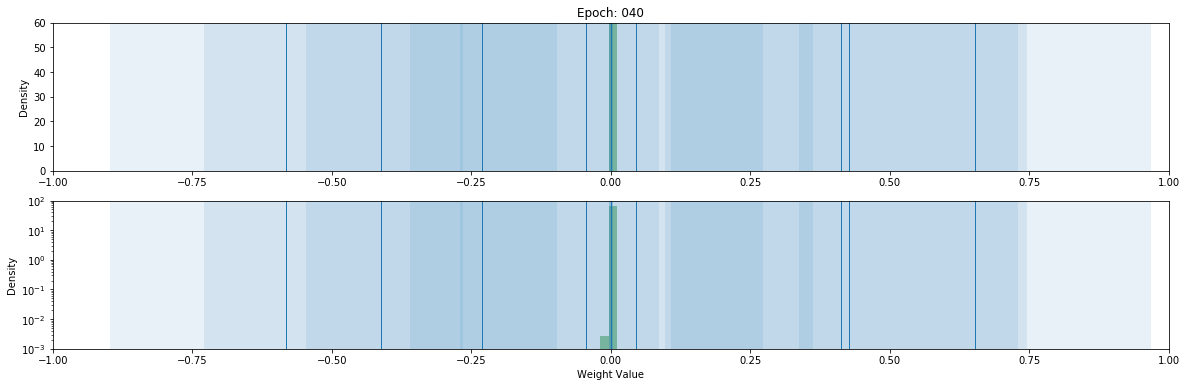

Epoch: 40. Test Accuracy: 79.76


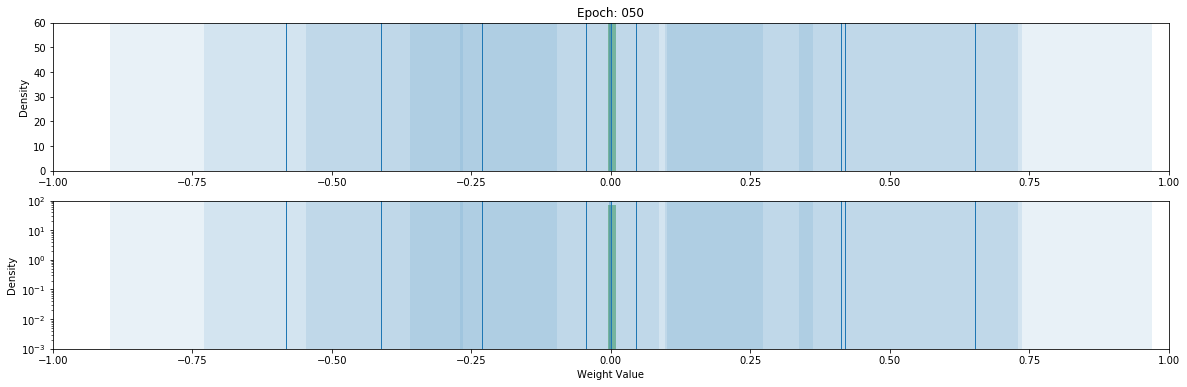

Epoch: 50. Test Accuracy: 78.59
[-0.49703066 -0.32119185 -0.13721731 -0.02209719  0.02263615  0.22911075
  0.41614494  0.53603214]
0
1
2
3
4
5
6
7
Retrain Test: 78.59, Retrain Validation: 79.48, Prune Test: 51.68, Prune Validation: 51.09, Prune Sparsity: 99.99
Temp: 9
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


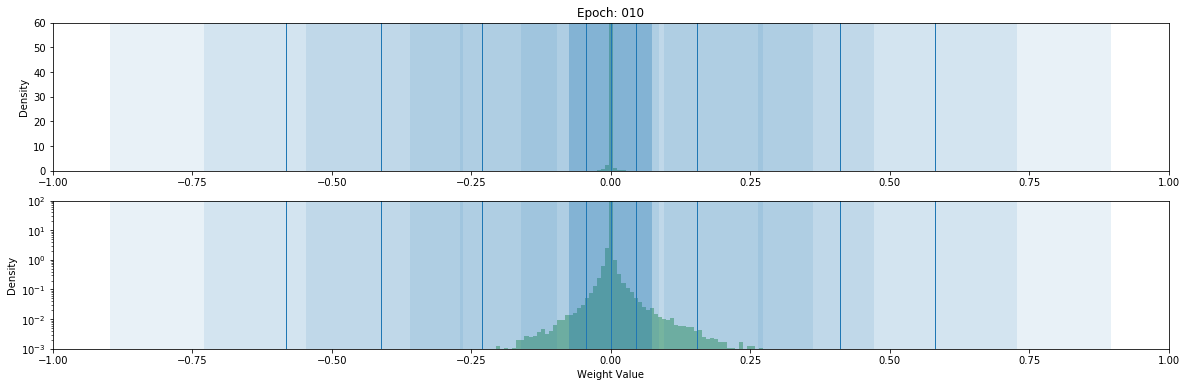

Epoch: 10. Test Accuracy: 93.61


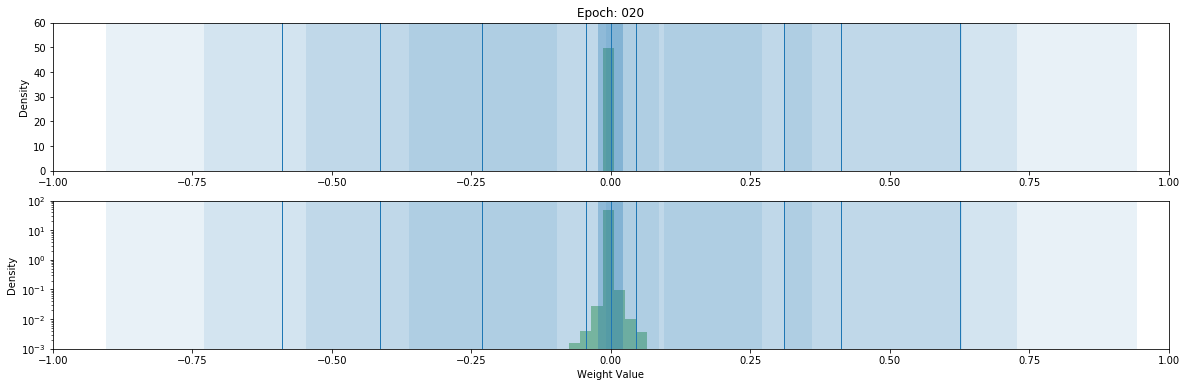

Epoch: 20. Test Accuracy: 90.92


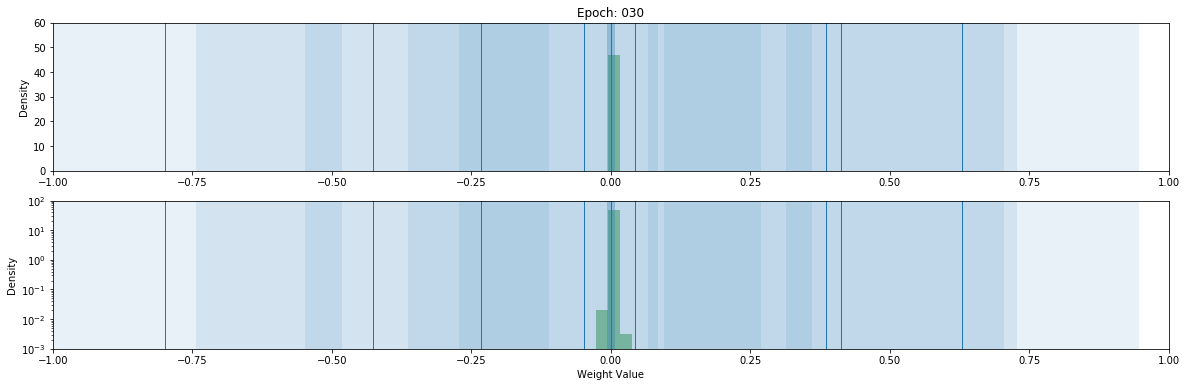

Epoch: 30. Test Accuracy: 84.15


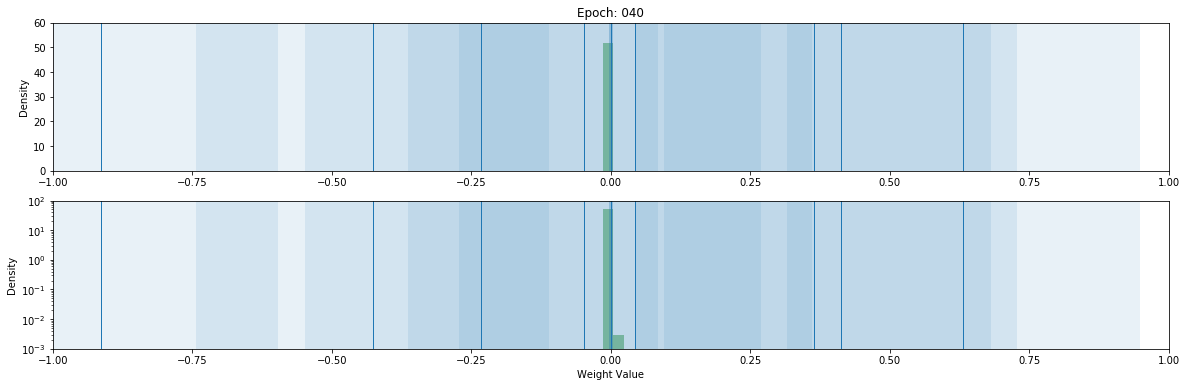

Epoch: 40. Test Accuracy: 85.79


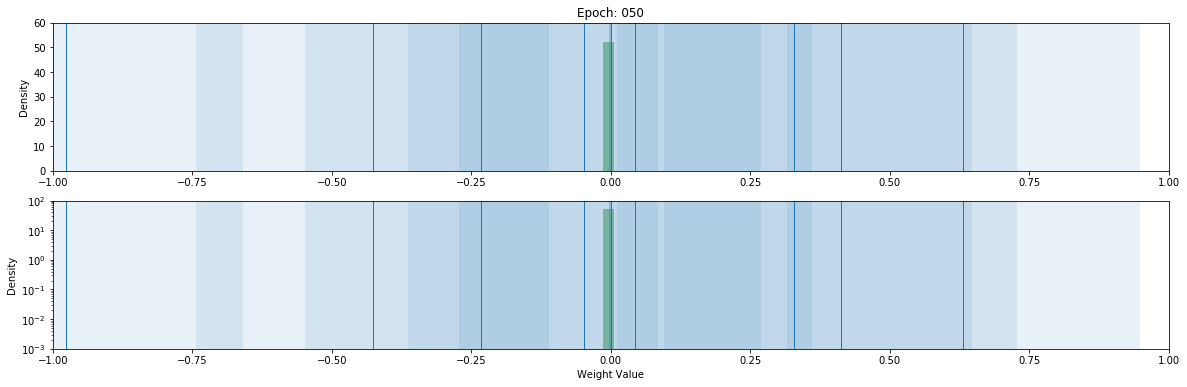

Epoch: 50. Test Accuracy: 85.58
[-0.70149677 -0.32931394 -0.13984311 -0.02394957  0.02174013  0.18607556
  0.37054037  0.52204798]
0
1
2
3
4
5
6
7
Retrain Test: 85.58, Retrain Validation: 86.21, Prune Test: 45.13, Prune Validation: 47.08, Prune Sparsity: 99.98
Temp: 13
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


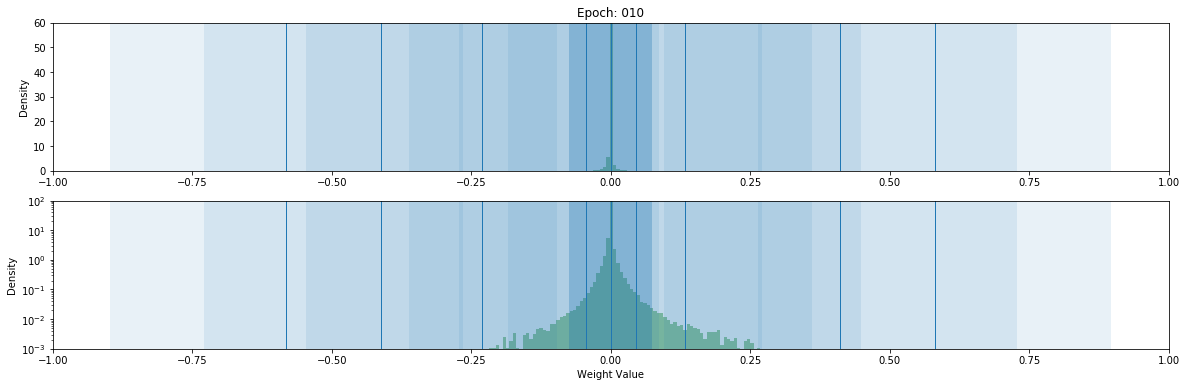

Epoch: 10. Test Accuracy: 93.56


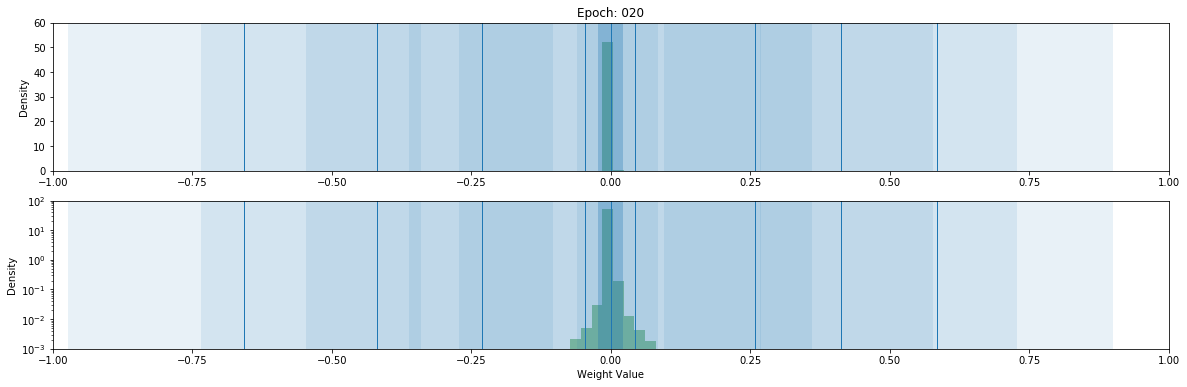

Epoch: 20. Test Accuracy: 86.61


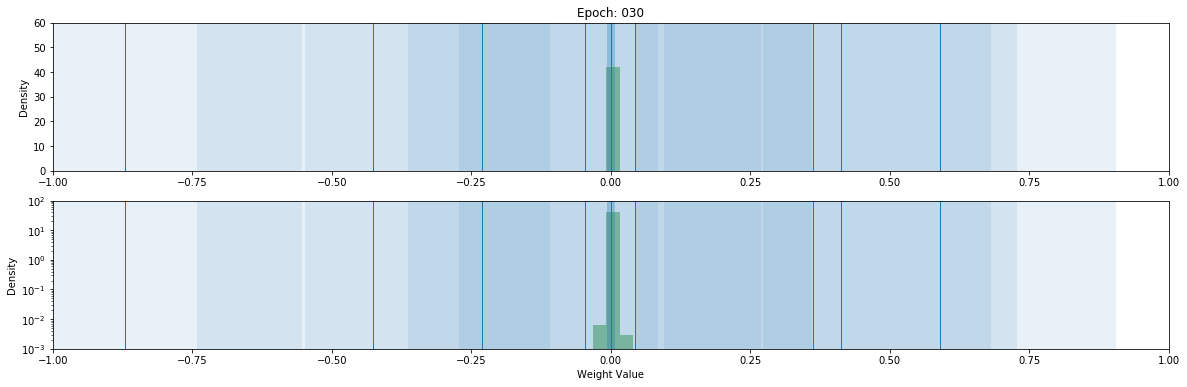

Epoch: 30. Test Accuracy: 89.73


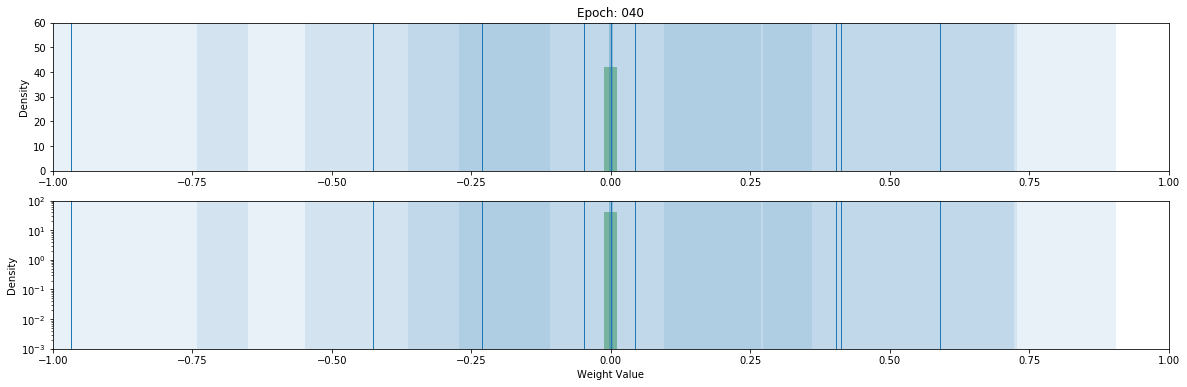

Epoch: 40. Test Accuracy: 88.57


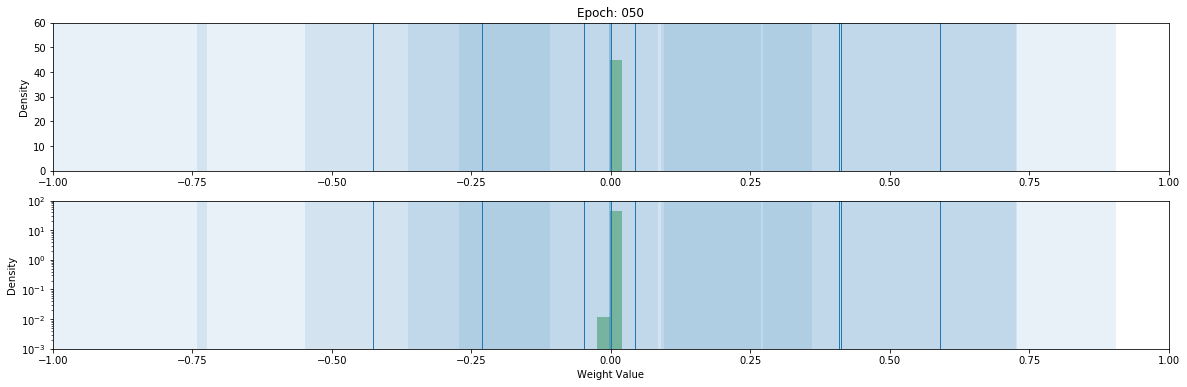

Epoch: 50. Test Accuracy: 88.40
[-0.73276368 -0.32844217 -0.13930389 -0.02362118  0.02193331  0.22599126
  0.41002704  0.5007655 ]
0
1
2
3
4
5
6
7
Retrain Test: 88.40, Retrain Validation: 88.31, Prune Test: 40.35, Prune Validation: 39.54, Prune Sparsity: 99.98
Temp: 17
0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 0.01


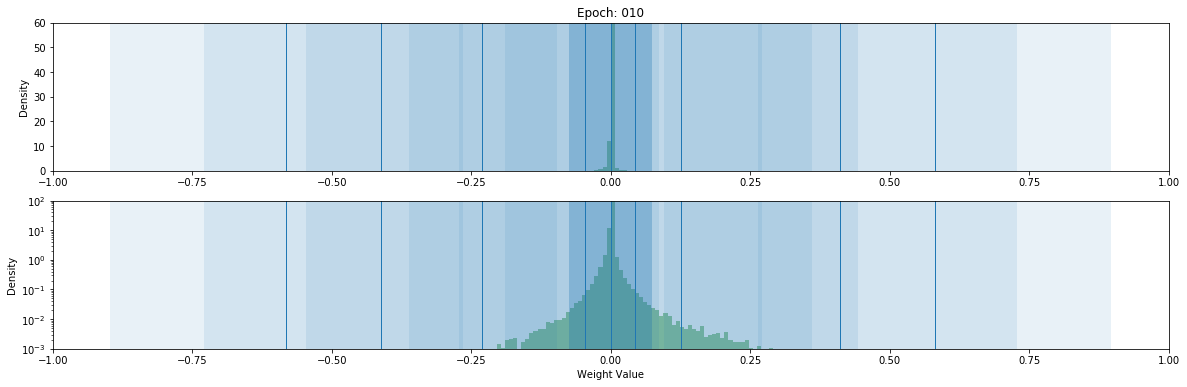

Epoch: 10. Test Accuracy: 92.87


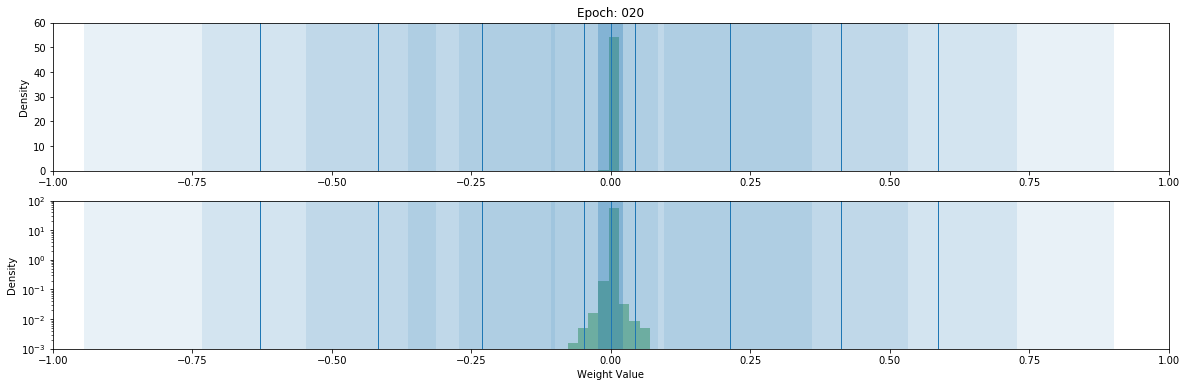

Epoch: 20. Test Accuracy: 92.22


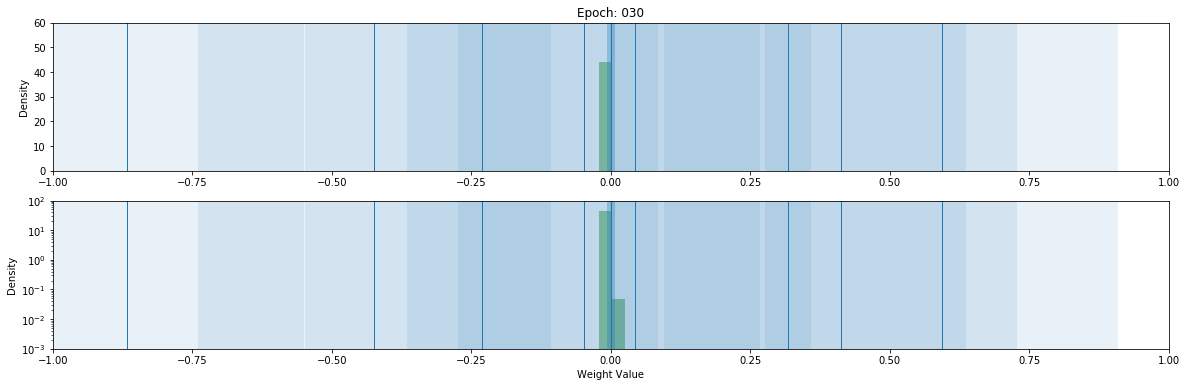

Epoch: 30. Test Accuracy: 90.32


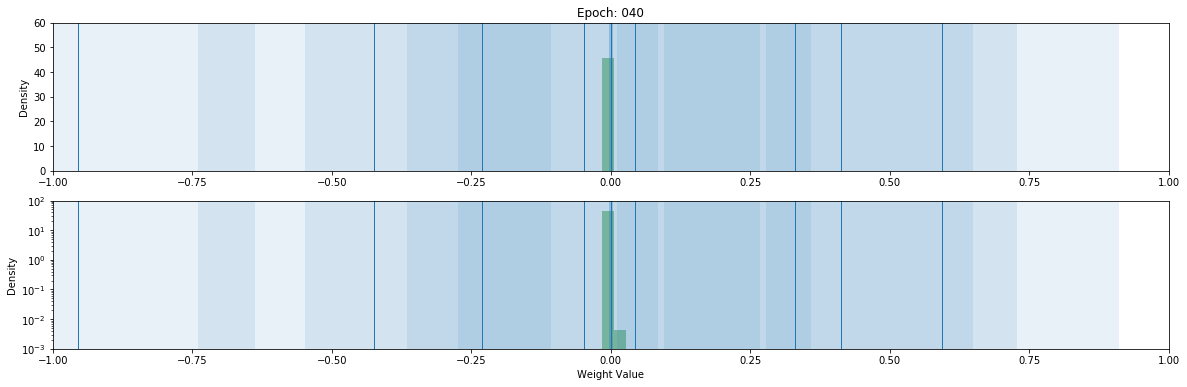

Epoch: 40. Test Accuracy: 89.31


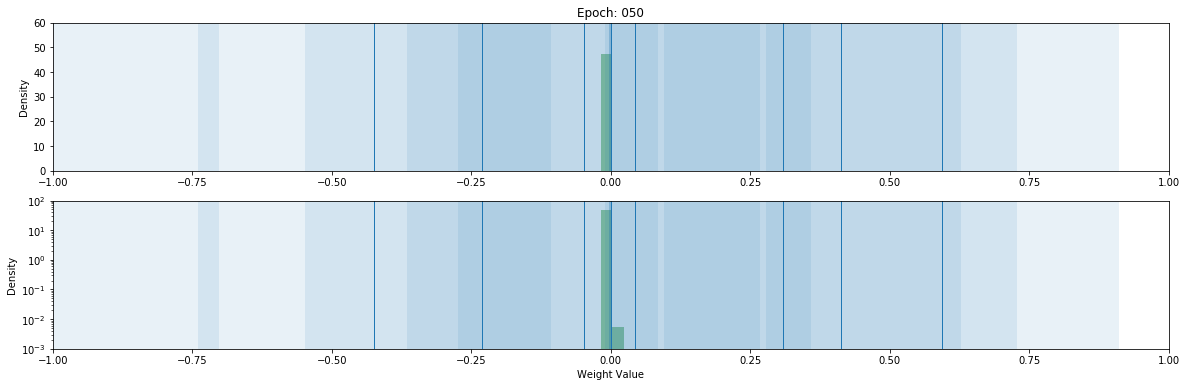

Epoch: 50. Test Accuracy: 90.97
[-0.72101663 -0.32773612 -0.1399098  -0.02423024  0.02142632  0.17557232
  0.36016698  0.50313884]
0
1
2
3
4
5
6
7
Retrain Test: 90.97, Retrain Validation: 90.96, Prune Test: 64.40, Prune Validation: 65.59, Prune Sparsity: 99.98


In [90]:
for temp in range (1, 20, 4):
    print ("Temp: {}".format(temp))
    model, gmp = retrain_model(alpha, beta, tau * temp, float(temp), mixtures, 'SWSModel', 'search', (5e-3, 1e-4, 3e-3), "", False)

In [105]:
Variable(search_validation_data(fetch="data")).cuda()

RuntimeError: cuda runtime error (39) : uncorrectable ECC error encountered at /opt/conda/conda-bld/pytorch_1518241554738/work/torch/lib/THC/generic/THCTensorCopy.c:20